<a id='root'></a>
PyUltraLight 2.20 General Development Notebook

(3 May 2021)

* Y. Wang: [yourong.f.wang@auckland.ac.nz](mailto:yourong.f.wang@auckland.ac.nz)
* R. Easther
***



<a id='init'></a>
# Initialization and Program Settings

## <font color=red>Big Red Reset Button</font> 

In [ ]:
%reset -f

## Loading Packages

In [1]:
###### Do not touch
MinVersion = 20

import PyUltraLight2 as PyUL

if (PyUL.S_version < MinVersion):
    raise RuntimeError("You need the latest PyULN!")

PyUL.PyULCredits()

import numpy as np

np.set_printoptions(suppress=True)

import math

import numba
import numexpr as ne
import time
import pyfftw
import os
import sys
import multiprocessing
import numpy

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec
import matplotlib.animation
from matplotlib.offsetbox import AnchoredText

import scipy.fft

import h5py
import IPython
from IPython.core.display import clear_output, display, Video

from numpy import sqrt, exp, log, log10, sin, cos, tan, pi

G_phi = (sqrt(5)-1)/2

%reload_ext autoreload
%autoreload 2


# Useful Aux Functions
ToCode = PyUL.convert
ToPhys = PyUL.convert_back
CB = PyUL.convert_between

printU = PyUL.printU

save_path = '2021_Paper1'

PyUL2.21.1: (c) 2020 - 2021 Wang., Y. and collaborators. 
Auckland Cosmology Group

Original PyUltraLight Team:
Edwards, F., Kendall, E., Hotchkiss, S. & Easther, R.
arxiv.org/abs/1807.04037


## Visualization Preferences
Initialize the colorised representations for plots and movies.

### Publication

In [2]:
plt.style.use('default')

plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['mathtext.fontset'] = 'dejavuserif'
plt.rcParams["text.usetex"]= False
plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.facecolor'] = 'w'

from matplotlib.colors import LinearSegmentedColormap
Palette = 'magma'
cyccol=['#000000', '#ffffff','#000000']
divcol=['#003262','#005b96','#ffffff','#d5a756','#B51700']
divcols=['#005b96','#ffffff','#d5a756']

CycPalette = LinearSegmentedColormap.from_list('myCyc', cyccol)

DivPalette  = LinearSegmentedColormap.from_list('myDiv', divcol)
DivPaletteS  = LinearSegmentedColormap.from_list('myDiv', divcols)

EFigSize = (20,12)
EFigSizeMono = (20,6)
VideoSize = (8,8)
FPS = 10
DPI = 72

FrameCap = 60 # Maximum Number of Frames to Animate

########################################

# BH Trajectory

Colors = np.array([[209,17,65],[0,177,89],[0,174,219],[243,119,53],[255,196,37]])/255

# NBody
ENStyle = '-.'
ENColor = '#ff6c0e' # NBody

EKColor = '#8dd9e7'
EPColor = '#fd8dc8'

# ULDM
EUStyle = '--'
EUColor = '#7f1717' # ULDM

EQColor = '#ccb603' # Kinetic 
ERColor = '#6cc25c' # Self-Interaction
EGColor = '#2c8899' # Particle Potential

# Totals
ETStyle = '-'
ETColor = '#080808'

# Auxiliary 
HelperStyle = 'k.'
EmphColor = 'black'
GeomColor = 'orange'

### Cinematic

In [ ]:
Palette = 'magma'
cyccol=['#000000', '#ffffff','#000000']
divcol=['#003262','#005b96','#ffffff','#d5a756','#B51700']
divcols=['#005b96','#ffffff','#d5a756']

CycPalette = LinearSegmentedColormap.from_list('myCyc', cyccol)

DivPalette  = LinearSegmentedColormap.from_list('myDiv', divcol)
DivPaletteS  = LinearSegmentedColormap.from_list('myDiv', divcols)



mpl.style.use('dark_background')

plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 4
plt.rcParams['lines.linewidth'] = 3

EFigSize = (20,12)
EFigSizeMono = (20,6)
VideoSize = (16,9)
DPI = 72
FPS = 60
FrameCap = -1 # Disabled

########################################

# BH Trajectory

Colors = np.array([[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,37]])/255


# NBody
ENStyle = '--'
ENColor = '#cfaf8a' # NBody

EKColor = '#cf838a'
EPColor = '#8acf99'

# ULDM
EUStyle = '-.'
EUColor = '#8d4b66' # ULDM

EQColor = '#4d7e4e' # Kinetic 
ERColor = '#545b7e' # Self-Interaction
EGColor = '#69567c' # Particle Potential

# Totals
ETStyle = '-'
ETColor = '#b7b7b7'

# Auxiliary 
HelperStyle = 'w.'
EmphColor = 'white'
GeomColor = 'cyan'

[**<font color=blue>Back to the Top</font>**](#root)
<a id='demos'></a>
# Precalculated Scenarios


<a id='demo_elli'></a>
## Example 1: 2Body Elliptical Orbit

In [ ]:
resol = 128

length = 10 # 1 code unit is ~38 kpc x (1e-22/m_a)^0.5
duration = 5 #1 code unit is ~70 Gyr (independent of axion mass assumption)

step_factor = 1

length_units = '' 
duration_units = '' 
s_mass_unit = ''
s_position_unit = '' 
s_velocity_unit = '' 
m_mass_unit = ''
m_position_unit = ''
m_velocity_unit = ''

m1 = 9 # User Input
Ratio1 = 1

m2 = 9 # User Input
Ratio2 = 0

Aphelion = 2.4 # User Input

e = 0.3 # Eccentricity. 0 -> Circle. 1 -> Parabola. 

#================================================================
# Do not touch

M = m1 + m2
xC = Aphelion

## Simulation always starts from Aphelion, in Centre-of-mass Frame

x2 = xC * m1/M # Bigger Mass, Smaller Initial Position
x1 = xC - x2

a1 = x1 / (1+e) # Semimajor Axis from Aphelion
a2 = x2 / (1+e)

xPeri1 = a1*(1-e)
xPeri2 = a2*(1-e)

## Initial Velocity is purely tangential.

yDot1 = np.sqrt(m2*x1/xC**2*(1-e)/(1+e))
yDot2 = np.sqrt(m1*x2/xC**2*(1-e)/(1+e))

particles = []
solitons = []

Halo1 = [m1, [x1,0,0], [0,yDot1,0],Ratio1,0]
Halo2 = [m2, [-x2,0,0], [0,-yDot2,0],Ratio2,0]

embeds = [Halo1,Halo2]

########### MODIFIER PARAMETERS
# Removes all ULDM Structures defined elsewhere in the IV and replaces them with a uniform wavefunction 
# with given probability amplitude (code unit).

Uniform = True
Density = 0


if not Uniform:
    print('The List of Soliton Conditions is:')
    print(solitons)
    
print('The List of BH Conditions is:')  
print(particles)

print('The List of Embedded Conditions is:')  
print(embeds)

PyUL.SolitonSizeEstimate(m2,length,resol,s_mass_unit,length_units,True)

particles = PyUL.PopulateWithStars(embeds,particles,
                                   rIn = 0.3,rOut = 0.52,InBias = 0, 
                                   NStars = 3, MassMax = 0)

In [ ]:
resol = 128

length = 5 # 1 code unit is ~38 kpc x (1e-22/m_a)^0.5
duration = 4 #1 code unit is ~70 Gyr (independent of axion mass assumption)

step_factor = 1

length_units = '' 
duration_units = '' 
density_unit = ''
s_mass_unit = ''
s_position_unit = '' 
s_velocity_unit = '' 
m_mass_unit = ''
m_position_unit = ''
m_velocity_unit = ''

m1 = 30 # User Input
m2 = 20 # User Input

Ratio1 = 1
Ratio2 = 1


Aphelion = 1 # User Input

e = 0.133 # Eccentricity. 0 -> Circle. 1 -> Parabola. 

#================================================================
# Do not touch

M = m1 + m2
xC = Aphelion

## Simulation always starts from Aphelion, in Centre-of-mass Frame

x2 = xC * m1/M # Bigger Mass, Smaller Initial Position
x1 = xC - x2

a1 = x1 / (1+e) # Semimajor Axis from Aphelion
a2 = x2 / (1+e)

xPeri1 = a1*(1-e)
xPeri2 = a2*(1-e)

## Initial Velocity is purely tangential.

yDot1 = np.sqrt(m2*x1/xC**2*(1-e)/(1+e))
yDot2 = np.sqrt(m1*x2/xC**2*(1-e)/(1+e))


particles = []
solitons = []

Halo1 = [m1, [x1,0,0], [0,yDot1,0],Ratio1,0]
Halo2 = [m2, [-x2,0,0], [0,-yDot2,0],Ratio2,0]

embeds = [Halo1,Halo2]

########### MODIFIER PARAMETERS
# Removes all ULDM Structures defined elsewhere in the IV and replaces them with a uniform wavefunction 
# with given probability amplitude (code unit).

Uniform = False
Density = 4e10
UVel = [0,0,0] # Uses s_velocity_units


if not Uniform:
    print('The List of Soliton Conditions is:')
    print(solitons)
    
print('The List of BH Conditions is:')  
print(particles)

print('The List of Embedded Conditions is:')  
print(embeds)

[**<font color=green>Go to Execution</font>**](#run)
<a id='demo_scatter'></a>
## Example 2: 2Body Scattering

In [ ]:
resol = 384

length_units = 'kpc' 
duration_units = 'Myr' 
s_mass_unit = 'M_solar_masses'
s_position_unit = 'kpc' 
s_velocity_unit = 'km/s' 

length = 6 #
duration = 25 #

step_factor = 1 # Large number to save sanity.

m1 = 3500 # User Input
m2 = 2400 # User Input


PyUL.SolitonSizeEstimate(m1,length,resol,s_mass_unit,length_units,True)
PyUL.SolitonSizeEstimate(m2,length,resol,s_mass_unit,length_units,True)

print(f"The (code) density is {PyUL.DensityEstimator(length,length_units,m1+m2,s_mass_unit)}")

Ratio1 = 0
Ratio2 = 0

Phase = 0 # Multiples of pi

b = 0.31 # Impact Parameter

vRel0 = 60 # Initial Speed along Collision Axis

Separation = 1.5

Uniform = False # if True, then there won't be solitons.
Density = 0
UVel = [0,0,0] # Uses s_velocity_units
density_unit = '' # Accepted units: 'MSol/pc3', 'kg/m3', and '' for dimensionless units

m_mass_unit = s_mass_unit
m_position_unit = s_position_unit
m_velocity_unit = s_velocity_unit

#================================================================
# Do not touch

# Unit 1
y1 = Separation*m2/(m1+m2)
x1 = b*m2/(m1+m2)
yDot1 = vRel0*m2/(m1+m2)


# Unit 2
y2 = Separation*m1/(m1+m2)
x2 = b*m1/(m1+m2)
yDot2 = vRel0*m1/(m1+m2)


particles = []
solitons = []
embeds = [] 

Composite1 = [m1,[x1,y1,0],[0,-yDot1,0],Ratio1,Phase*np.pi/2]
Composite2 = [m2,[-x2,-y2,0],[0,yDot2,0],Ratio2,-Phase*np.pi/2]

embeds.append(Composite1)
embeds.append(Composite2)

print(particles,solitons,embeds,sep='\n\n')
plt.show()


fig,ax = PyUL.VizInit_P(length,length_units,resol,embeds,
              solitons,s_position_unit, s_mass_unit,
              particles,m_position_unit)

print(PyUL.DensityEstimator(length,length_units,(m1+m2),s_mass_unit))

[**<font color=green>Go to Execution</font>**](#run)
<a id='demo_tya'></a>
## Example 3: 4Body Tangyuan

In [ ]:
resol = 64
length = 12# 1 code unit is ~38 kpc x (1e-22/m_a)^0.5
duration = 5 #1 code unit is ~70 Gyr (independent of axion mass assumption)

step_factor = 1

length_units = '' 
duration_units = '' 
s_mass_unit = ''
s_position_unit = '' 
s_velocity_unit = '' 
m_mass_unit = ''
m_position_unit = ''
m_velocity_unit = ''

# Density, if Uniform Background Flag is Set to 'True'
# 1 Code Density Unit is equal the universe's critical matter density, 2.67e-27 kg/m^3.
density_unit = '' # Accepted units: 'MSol/pc3', 'kg/m3', and '' for dimensionless units

r = 1.4
m = 20

Ratio = 1

v = np.sqrt(m/r*(1+2*np.sqrt(2)))/2

vM = 1 # Change Magn. 

#================================================================
# Do not touch

v = vM * v
print("The initial tangential speed is %.4f \n" % (v))

Halo1 = [m,[r,0,0],[0,v,0],Ratio,0]
Halo2 = [m,[0,r,0],[-v,0,0],Ratio,0]
Halo3 = [m,[-r,0,0],[0,-v,0],Ratio,0]
Halo4 = [m,[0,-r,0],[v,0,0],Ratio,0]

embeds = [Halo1, Halo2, Halo3, Halo4]
#Soliton parameters are mass, position, velocity and phase (radians)

solitons = []
#particles = [[6,[-3,-3,0],[5,5,0]]]
particles = []

Uniform = False
Density = 0.05
UVel = [0,0,0] # Uses s_velocity_units

if Uniform:
    embeds = []
    BH1 = [m,[r,0,0],[0,v,0]]
    BH2 = [m,[0,r,0],[-v,0,0]]
    BH3 = [m,[-r,0,0],[0,-v,0]]
    BH4 = [m,[0,-r,0],[v,0,0]]
    particles = [BH1, BH2, BH3, BH4]


[**<font color=green>Go to Execution</font>**](#run)
<a id='demo_QM'></a>
## Example 4: Merger From Rest

In [ ]:
resol = 128

length = 4 # 1 code unit is ~38 kpc x (1e-22/m_a)^0.5
duration = 20 #1 code unit is ~70 Gyr (independent of axion mass assumption)

SimL = length/2  # Simulation Starting Region

step_factor = 1

NEmbed = 8

RandomSeed = 303022

###
np.random.seed(RandomSeed)

length_units = 'kpc' 
duration_units = 'Myr' 
s_mass_unit = 'M_solar_masses'
s_position_unit = 'kpc' 
s_velocity_unit = 'km/s' 

m_mass_unit = 'M_solar_masses'
m_position_unit = 'kpc' 
m_velocity_unit = 'km/s' 

MassMax = 4000 #
MassMin = 3000

RatioMax = 0.
RatioMin = 0.


#================================================================
# Do not touch

embeds = []
particles = []

for i in range(NEmbed):
    Location = ([(np.random.random()-1/2)*SimL/2,(np.random.random()-1/2)*SimL/2,0])
    
    Speed = 200*np.random.random()
    
    Angle = 2*np.pi*np.random.random()
    
    Velocity = [Speed*np.cos(Angle),Speed*np.sin(Angle),0]
    
    Ratio = RatioMax
    
    Mass = MassMin + np.random.random()*(MassMax-MassMin)
    
    Phase = np.pi*(np.random.random())/2
    
    embeds.append([Mass,Location,Velocity,Ratio,Phase])
    
solitons = []

Uniform = False
Density = 0
UVel = [0,0,0] # Uses s_velocity_units
density_unit = '' # Accepted units: 'MSol/pc3', 'kg/m3', and '' for dimensionless units

print(PyUL.DensityEstimator(length,length_units,(m1+m2),s_mass_unit))

[**<font color=green>Go to Execution</font>**](#run)
<a id='demo_QM'></a>
## Example 5: Dwarf Galaxies

In [ ]:
resol = 128

length = 16# 1 code unit is ~38 kpc x (1e-22/m_a)^0.5
duration = 10 #1 code unit is ~70 Gyr (independent of axion mass assumption)

step_factor = 1

NStar = 10 # Test stars per galaxy

RIn = 1
ROut = 2.3
RBaseline = 20 # Smaller galaxies are denser in stars.
MaxStarMass = 0

RandomSeed = 950209

###
np.random.seed(RandomSeed)

length_units = '' 
duration_units = '' 
s_mass_unit = ''
s_position_unit = '' 
s_velocity_unit = '' 
m_mass_unit = ''
m_position_unit = ''
m_velocity_unit = ''



embeds = [[5,[0,-3,0],[-0.03,0.375,0],0,np.pi],[7,[0,2,0],[0.02,-0.25,0],0,0]]

particles = []

def FOSR(m,r):
    return np.sqrt(m/r)

#================================================================
# Do not touch

for j in range(len(embeds)):
    
    Galaxy = embeds[j]
    
    GPos = np.array(Galaxy[1])
    GVel = np.array(Galaxy[2])
    GMass = Galaxy[0]
    
    RFac = GMass/20
    
    NStarL = np.random.randint(-2, 4)
    for i in range(NStar+NStarL):

        r = (np.random.random()*(ROut-RIn) + RIn)*GMass/RBaseline
        
        theta = 2*np.pi*np.random.random()
        v = FOSR(GMass,r)

        Position = np.array([r*np.cos(theta),r*np.sin(theta),0]) + GPos
        Velocity = np.array([v*np.sin(theta),-v*np.cos(theta),0]) + GVel
        
        Mass = MaxStarMass*np.random.random()
        
        particles.append([Mass,Position.tolist(),Velocity.tolist()])


solitons = []

Uniform = False
Density = 0
UVel = [0,0,0] # Uses s_velocity_units
density_unit = '' # Accepted units: 'MSol/pc3', 'kg/m3', and '' for dimensionless units
#print(*embeds, sep = "\n")

#print(*particles, sep = "\n")


## [Dynamical Friction with Soliton]

In [ ]:
resol = 128

# Space Settings
length = 10 # 1 code unit is ~38 kpc x (1e-22/m_a)^0.5
length_units = 'kpc'  # Accepted units: 'm', 'km', 'pc', 'kpc', 'Mpc', 'ly', and '' for dimensionless units.

# Time Settings
duration = 10 #1 code unit is ~70 Gyr (independent of axion mass assumption)
duration_units = 'Myr'  # Accepted units: 's', 'yr', 'kyr', 'Myr', and '' for dimensionless units

step_factor = 1

# Recommended Save Number Cap: 120
# Depending on resolution, this could require significant disk space.

##================================================================
## Other Flags
# Set units for soliton parameters
s_mass_unit = 'M_solar_masses'    #Accepted units: 'kg', 'solar_masses', 'M_solar_masses', and '' for dimensionless units
s_position_unit = 'kpc' #Accepted units: 'm', 'km', 'pc', 'kpc', 'Mpc', 'ly', and '' for dimensionless units
s_velocity_unit = 'km/s' #Accepted units: 'm/s', 'km/s', 'km/h', 'c', and '' for dimensionless units

# Rules ditto.
m_mass_unit = 'M_solar_masses'
m_position_unit = 'kpc'
m_velocity_unit = 'km/s'


dBL = PyUL.convert_between(PyUL.DefaultDBL(v = 1e6),'m',length_units,'l')

if dBL >= length:
    print(f'Not Good! Nominal de Broglie wavelength of axion: {dBL}{length_units} ')

mS = 600 # User Input
mP = 1800 # User Input

Ratio1 = 0.0
Ratio2 = 0.0

Uniform = False # if True, then there won't be solitons.
Density = 0
UVel = [0,0,0] # Uses s_velocity_units
density_unit = '' # Accepted units: 'MSol/pc3', 'kg/m3', and '' for dimensionless units

embeds = []

solitons = [[mS,[0,0.5,0],[0,0,0],0]]

particles = [[mP,[0,-1,0],[0,50,0]]]

PyUL.SolitonSizeEstimate(mS,length,resol,s_mass_unit,length_units,True)


[**<font color=green>Go to Execution</font>**](#run)
<a id='demo_byo'></a>
## [Dynamical Friction with Uniform Background]

In [ ]:
######## USER PARAMETERS BELOW ################################

speed, s_velocity_unit = (100,'km/s')

QuantumWind = True # Galileo Switch

Automatic = True

AutoMult = 1/4 # For how long should you run?

BHSpeedMultiplier = 0 # 1 = Comoving, -1 = Against, 0 = Stationary 

length_units = 'kpc'

duration = 90 #1 code unit is ~70 Gyr (independent of axion mass assumption)

duration_units = 'Myr'  # Accepted units: 's', 'yr', 'kyr', 'Myr', and '' for dimensionless units

NdB = 8  # Number of deBroglie wavelengths that fit in the simulation
rPB = 16 # Resolution per full matter wavelength.

mBH1, m_mass_unit = 10 , 'M_solar_masses'

Uniform = True
Density = 1e7 # 1 Code unit is 0.31*Critical Density
density_unit = 'Crit'


######## AUTOMATIC PROCESSING BELOW ################################

# de Broglie in Lab Frame is the Quantum Wind wavelength

if speed == 0:
    lbasic = 1
else:
    lbasic = PyUL.convert_back(np.pi*2/PyUL.convert(speed,s_velocity_unit,'v'),length_units,'l')

resol = NdB*rPB

print(f'Quantum de Broglie wavelength: {lbasic:.4g} {length_units}')

length = NdB*lbasic # Can be changed to fit more wavelengths.

MaxDuration = CB((CB(length,length_units,'m','l')/CB(speed,s_velocity_unit,'m/s','v')),'s',duration_units,'t')
print(f'Maximum allowed duration: {MaxDuration:.1f} {duration_units}')

if Automatic:
    duration = MaxDuration * AutoMult

print(f'Simulation domain edge length: {length:.4g} {length_units}')


#Density = PyUL.DensityEstimator(length,length_units,(TotalMass),s_mass_unit)/1000
##================================================================
## Other Units
# Set units for soliton parameters
    
s_position_unit = length_units
m_position_unit = length_units
m_velocity_unit = s_velocity_unit

s_mass_unit = ''

# 1 Code Density Unit is equal the universe's critical matter density, 2.67e-27 kg/m^3.
 # Accepted units: 'MSol/pc3', 'kg/m3', and '' for dimensionless units

##================================================================

if QuantumWind:
    
    
    particles = [[mBH1,[0,length/4,0],[0,-speed*BHSpeedMultiplier,0]]]
    #particles = [[mBH1,[0,0,0],[0,-speed*BHSpeedMultiplier,0]]]
    
    solitons = []

    embeds = []

    UVel = [0,-speed,0] 
    
else:

    #particles = [[mBH1,[0,-length/4,0],[0,speed,0]]]
    #particles = [[mBH1,[0,0,0],[0,speed,0]]]

    solitons = []

    embeds = []

    UVel = [0,0,0]
    
    
speedSI = -CB(speed,s_velocity_unit,'m/s','v')
mBHSI = CB(mBH1,'M_solar_masses','kg','m')

ldbM = CB(lbasic,length_units,'m','l')

beta = 2*np.pi*PyUL.G*mBHSI/speedSI**2/(ldbM)

print('Beta:', beta)

[**<font color=green>Go to Execution</font>**](#run)
<a id='demo_QM'></a>
## [Generating a Dispersion Background]

In [ ]:
# length = NdB*lbasic / 10

duration = 70 #1 code unit is ~70 Gyr (independent of axion mass assumption)

SimL = length/4  # Simulation Starting Region

NEmbed = 4

###

MassMax = 2200 #
MassMin = 1300

RatioMax = 0.
RatioMin = 0.

#================================================================
# Do not touch

embeds = []
particles = []
TotalMass = 0
for i in range(NEmbed):
    Location = ([(np.random.random()-1/2)*SimL/2,(np.random.random()-1/2)*SimL/2,0])
    
    Speed = 200*np.random.random()
    
    Angle = 2*np.pi*np.random.random()
    
    Velocity = [Speed*np.cos(Angle),Speed*np.sin(Angle),0]
    
    Ratio = RatioMax
    
    Mass = MassMin + np.random.random()*(MassMax-MassMin)
    
    TotalMass += Mass
    
    Phase = np.pi*(np.random.random())/2
    
    embeds.append([Mass,Location,Velocity,Ratio,Phase])
    
solitons = []

Uniform = False
UVel = [0,0,0] # Uses s_velocity_units
density_unit = '' # Accepted units: 'MSol/pc3', 'kg/m3', and '' for dimensionless units

Density = PyUL.DensityEstimator(length,length_units,(TotalMass),s_mass_unit)

print(Density)

## Complex ULDM Structures

In [ ]:
resol = 128

length = 8 # 1 code unit is ~38 kpc x (1e-22/m_a)^0.5
duration = 0.2 #1 code unit is ~70 Gyr (independent of axion mass assumption)

length_units = ''
duration_units = '' 
s_mass_unit = ''
s_position_unit = '' 
s_velocity_unit = '' 
m_mass_unit = ''
m_position_unit = ''
m_velocity_unit = ''
density_unit = ''


Uniform = True
Density = 1

particles = [[0,[1,1,0],[0,0,0]]]
embeds = []

solitons = [[6,[0,0,0],[0,1,0],0]]

UVel = [0,0,0]

PyUL.SolitonSizeEstimate(10,length,resol,'',length_units,Plot = True, Density = Density)

## Particle-Based Dynamical Friction
No ULDM, just stars.

In [ ]:
resol = 128

length = 25 # 1 code unit is ~38 kpc x (1e-22/m_a)^0.5
duration = 200 #1 code unit is ~70 Gyr (independent of axion mass assumption)

length_units = 'kpc'
duration_units = 'Myr' 

m_mass_unit = 'M_solar_masses'
m_position_unit = 'kpc'
m_velocity_unit = 'km/s'
density_unit = ''

IncomingParticle = [5,[0,-length/4,0],[0,20,0]]

particles = [IncomingParticle]

NObs = 12

CloudStyle = 'Rectangle'

for i in range(NObs):
    Angle = np.random.random()*np.pi*2
    
    mass = np.random.random()*1
    
    #posX = (np.random.random()-1/2)*length*0.2
    
    #posY = np.random.random() *3*length/10 - length/10 
    
    posX = (np.random.random()-1/2)*length
    
    posY = np.random.random() *3*length/5 - length/10 
    
    position = [posX,posY,0]
    
    particles.append([mass,position,[0,0,0]])

embeds = []
solitons = []
UVel = [0,0,0]
Uniform = True
Density = 1000
s_mass_unit = ''
s_position_unit = '' 
s_velocity_unit = '' 


[**<font color=green>Go to Execution</font>**](#run)
<a id='demo_byo'></a>
# Build Your Own


## How to create new objects.

* **Particle Config: ** 
```python
[mass,[position],[velocity]]
```

* **Soliton Config: **
```python
[mass,[position],[velocity],phase]
```

* **Embedded Soliton Config: **
```python
[total_mass,[position],[velocity],mBH/total_mass,phase]
```

* **Uniform Wavefront (Previously QuantumWind): **

```python
UVel
```
* **Nonvanishing Dispersion: **


**NOTE**: Embedded solitons and Uniform backgrounds inherit the soliton units setting.

In [ ]:
resol = 256
# Space Settings
length = 15 # 1 code unit is ~38 kpc x (1e-22/m_a)^0.5
length_units = 'kpc'  # Accepted units: 'm', 'km', 'pc', 'kpc', 'Mpc', 'ly', and '' for dimensionless units.

# Time Settings
duration = 8e-6 #1 code unit is ~70 Gyr (independent of axion mass assumption)
duration_units = ''  # Accepted units: 's', 'yr', 'kyr', 'Myr', and '' for dimensionless units

step_factor = 1

# Recommended Save Number Cap: 120
# Depending on resolution, this could require significant disk space.

##================================================================
## Other Flags
# Set units for soliton parameters
s_mass_unit = ''     #Accepted units: 'kg', 'solar_masses', 'M_solar_masses', and '' for dimensionless units
s_position_unit = '' #Accepted units: 'm', 'km', 'pc', 'kpc', 'Mpc', 'ly', and '' for dimensionless units
s_velocity_unit = '' #Accepted units: 'm/s', 'km/s', 'km/h', 'c', and '' for dimensionless units

# Rules ditto.
m_mass_unit = 'M_solar_masses'
m_position_unit = 'kpc'
m_velocity_unit = 'm/s'

# Density, if Uniform Background Flag is Set to 'True'
# 1 Code Density Unit is equal the universe's critical matter density, 2.67e-27 kg/m^3.
density_unit = '' # Accepted units: 'MSol/pc3', 'kg/m3', and '' for dimensionless units

##================================================================

mBH1 = 1

BH1 = [mBH1,[0,-0.3,0],[0,9e4,0]]

particles = [BH1]

soliton1=[2000,[0,0,0],[0,0,0],-0]

solitons = [soliton1]

embeds = []

########### MODIFIER PARAMETERS

# Removes all ULDM Structures defined elsewhere in the IV and replaces them with a uniform wavefunction 
# with given probability amplitude (code unit).

Uniform = False
Density = 4e10
UVel = [0,0,0] # Uses s_velocity_units
#Density = 0


if not Uniform:
    print('The List of Soliton Conditions is:')
    print(solitons)
    print('The List of Embedded Soliton Conditions is:')  
    print(embeds)
    
print('The List of BH Conditions is:')  
print(particles)



[**Back to the Top**](#root)
<a id='run'></a>
# Compiling and Go

This creates a timestamped folder using the current settings, and the integrator stores all requested files in it too.

## Initial Condition Sketch

In [3]:
fig,ax = PyUL.VizInit2D(length,length_units,resol,embeds,
              solitons,s_position_unit, s_mass_unit,
              particles,m_position_unit, Uniform, Density, UVel)

NameError: name 'length' is not defined

## <font color=orange>Gravitational Field Smoothing</font>

Instead of coding in the idealistic m/r potential, we approximate it with a Plummer sphere. 

The modified potential is a useful approximation of a point mass in a distance, and puts an exponential cap on the infinite potential well, which reduces the impact of numerical artefacts.


The smoothing factor, a = 1/l, is defined here.


The differences between the two potentials are characterised in the program output box.

In [4]:
lengthC = PyUL.convert(length, length_units, 'l')

GridlenC = lengthC/(resol)

print(f"The grid subdivision is {length/resol:.4f} in specified units. This is {GridlenC:.4f} code units.")

central_mass = 0 # Not Implemented Anymore. Keep for backwards compatibility.

ExtraSharp = 1 # HWHM / Grid Size
#================================================================

# print((2+PyUL.LW(np.exp(-2))))

a = np.sqrt(3)/lengthC*resol * ExtraSharp

# a = 400

print(f"\nSmoothing factor is {a:.3f}, \nThe particle's Plummer radius is {1/ToCode(a,'pc','l'):.4g} pc")

NameError: name 'length' is not defined

[**RUN BATCH**](#scan)

[**RUN SINGLE**](#solo)

## Parameter Scanning  / Batch Execution
<a id='scan'></a>
Please refer to the separate 'ParamScan' notebook for effective parameter scanning analysis.

In [46]:
ExperimentName = '/Pub1_ERS_3'

batch_path = 'Batches'

PyUL.DSManagement(batch_path)

batch_path += ExperimentName

PyUL.DSManagement(batch_path)

[ Batches ] : The current size of the folder is 49.797 Mib
[ Batches ] : Do You Wish to Delete All Files Currently Stored In This Folder? [Y] 



[ Batches/Pub1_ERS_3 ] : The current size of the folder is 0.0 Mib
[ Batches/Pub1_ERS_3 ] : Save Folder Created.


In [ ]:
DensityIndex = np.linspace(4,8,9)
MassIndex = np.linspace(-2,2,5)

print(DensityIndex)

DensityPool = (10**DensityIndex).tolist()
MassPool = (10**MassIndex).tolist()

In [ ]:
SPool = (4*2**np.arange(8)*50)

print(SPool)

SPool = SPool.tolist()

In [50]:
baseConfig = './Reusable/QDrag1_HD' # Path to base config file. won't be touched.
# Currently supported scan parameters: 
#Density, Resolution, TM_Mass, TM_vY, UVelY, Step_Factor, Scaling, Smoothing

ScanParams = ['Step_Factor','Smoothing']

ValuePool = [[0.2],[50,100,200,400,800,1600,3200,6400,12800]]

In [51]:
printU('All files in the directory will be overwritten. Proceed? [Y]')

if input() == 'Y':
    NRuns, save_options = PyUL.ParameterScanGenerator(baseConfig,ScanParams,
                            ValuePool,batch_path, 
                           KeepSmooth = False,
                            KeepResol = False,
                           SaveSpace = False)

PyUL2.  Sys: All files in the directory will be overwritten. Proceed? [Y]
Y
PyUL2.ParamScan: Automated scan will be performed over 2 parameters.
There will be 9 separate simulations. They are:
[('Step_Factor', [0.2]), ('Smoothing', [50, 100, 200, 400, 800, 1600, 3200, 6400, 12800])]
(Units are defined in the donor config file)
Generated config file for PScan_F01_A01
Generated config file for PScan_F01_A02
Generated config file for PScan_F01_A03
Generated config file for PScan_F01_A04
Generated config file for PScan_F01_A05
Generated config file for PScan_F01_A06
Generated config file for PScan_F01_A07
Generated config file for PScan_F01_A08
Generated config file for PScan_F01_A09


In [52]:
FullSim = True
T0 = time.time()
runs = os.listdir(batch_path)
runs.sort()

Run = 0

for run_folder in runs:
    
    if os.path.isdir(f'{batch_path}/{run_folder}'):
        
        RunText = f'Simulation #{Run+1} out of {NRuns}'
        PyUL.evolve(batch_path,run_folder,
            NBodyInterp = FullSim, SelfGravity = FullSim, NBodyGravity = True, 
            Silent = True, Shift = False, AutoStop = True, AutoStop2 = False, Message = RunText)

        Run +=1

        print(f'Simulation {Run} finished.')
        time.sleep(2)
        
import IPython
IPython.display.Audio("Done.mp3",autoplay=True)

print(f"{time.time()-T0:.3f}s")

Build 2021 May 05
Message: Simulation #9 out of 9
PyUL2.Runtime: Simulation name is ./Batches/Pub1_ERS_3/PScan_F01_A09
PyUL2.Runtime: 128 Resolution for 32Myr
PyUL2.Runtime: Simulation Started at 12/05/2021, 13:54:14.
PyUL2.Runtime: Taking 434 ULDM steps


[●●●◎○◎●●●●●●●●●●●●●●●●●●] 88% IO   Exp. Time: 12/05/2021, 13:55:39 (Prev.: 0.21s) [V=201.12 / Tg.V=200.15]
Test mass has stopped at step 379!
Integrated Time is 28.018Myr
[●●●●◎○◎●●●●●●●●●●●●●●●●●] 88% IO   Exp. Time: 12/05/2021, 13:55:38 (Prev.: 0.19s) [V=204.72 / Tg.V=200.15]
Simulation Concluded at step 380!


PyUL2.Runtime: Run Complete. Time Elapsed (d:h:m:s): 0:0:1:14.12
Simulation 9 finished.
768.715s


## Single Run
<a id='solo'></a>

[**<font color=blue>Back to the Top</font>**](#root)
<a id='ULSettings'></a>
Integrator Settings Parameters

In [ ]:
PyUL.DSManagement(save_path)

In [ ]:
start_time = 0. # For solitons only: Pre-evolve the wavefunction phase.

NS = 32

save_format = 'npy' # npy, npz, hdf5

step_factor = 1

save_number = 300


PyUL.DispN(duration,duration_units,length,length_units,resol,step_factor,save_number)


# All supported save options: 
# 3Wfn 3Density 2Density Energy 
# 1Density NBody 3Grav 2Grav DF 
# 2Phase Entropy 1Grav 3GravF 2GravF 1GravF

# You can also set it to 'Minimum' to only save all 1D mesh Data.
Save_Options = '2Density 2GravF 2Phase Energy 1Density NBody 1Grav DF Entropy 1GravF'

#This Boolean List is for program's internal use
save_options = PyUL.SaveOptionsDigest(Save_Options)

In [ ]:
NoInteraction = False

FullSim = True

Name = ''

Loaded = {}

Initpath = ''

#Draft = True # Soliton Resolution Switch. Production Resol: 1e-5, Draft: 1e-3.
#EdgeClear = False # Clear Edge (Rudimentary Sponge)
#DumpInit = False # Dump Initial Conditions into ChplUltra-compliant Files
#IsoP = False # Use Isolated Potential
#UseDispSponge = False # Use Dispersive Sponge (Default Setting: Sponge Thickness = 1/4*L)
#NBodyInterp = False
#SelfGravity = True
# InitWeight: [0,1]. The weight of preloaded wavefunction.
# Set InitWeight to -1 to utilize the phase only.

run_folder = PyUL.GenerateConfig(NS, 0, length, length_units,
                                 resol, duration, duration_units, step_factor,
                                 save_number, Save_Options, save_path,
                                 save_format, s_mass_unit, s_position_unit,
                                 s_velocity_unit, solitons,start_time,
                                 m_mass_unit, m_position_unit, m_velocity_unit,
                                 particles,embeds, Uniform,Density,density_unit,
                                 a,0,UVel,NoInteraction,Name)

PyUL.evolve(save_path,run_folder,
            DumpInit = False, DumpFinal = False, UseInit = False,
            EdgeClear = False, IsoP = False, UseDispSponge = False, Shift = False,
            SelfGravity = FullSim, NBodyInterp = FullSim, NBodyGravity = True, 
            Silent = NoInteraction, AutoStop = True, AutoStop2 = False,
            InitPath = Initpath, InitWeight = 1)

IPython.display.Audio("Done.mp3",autoplay=True)

[**<font>Back to the Top</font>**](#root)
<a id='plot'></a>
# Single-Run Analysis Suite

## Loading Data and Config
<a id='Load'></a>

In [ ]:
save_path = batch_path
TimeStamp = PyUL.Runs(save_path)
clear_output()
loc = './' + save_path + '/' + TimeStamp
# Reload Config.. Why don't I use a class?
NS, central_mass, length, length_units, resol, duration, duration_units, step_factor, save_number, save_options, save_format, s_mass_unit, s_position_unit, s_velocity_unit, solitons,start_time, m_mass_unit, m_position_unit, m_velocity_unit, particles, embeds, Uniform,Density, density_unit ,a, B, UVel = PyUL.LoadConfig(loc)

if save_number == -1:
    sim_number = PyUL.ULDStepEst(duration,duration_units,
                                          length,length_units,
                                          resol,step_factor, 
                                          save_number = -1)
else:
    sim_number = save_number
    
# Dict of Run Data
EndNum, Loaded = PyUL.Load_npys(loc,save_options, LowMem = False)

In [ ]:
Load2D = False
Load1D = True

if Load2D:
    phasedata = Loaded['2Phase']
    #phidata  = Loaded['2Grav']
    phidataF = Loaded['2GravF']
    data = Loaded['2Density']

if Load1D:
    #phi1D  = Loaded['1Grav']
    phiF1D = Loaded['1GravF']
    linedata = Loaded['1Density']

TMdata = Loaded['NBody']
graddata = Loaded['DF']

NBo = len(particles)

ToCode = PyUL.convert
ToPhys = PyUL.convert_back
CB = PyUL.convert_between

# Time
durationMyr = CB(duration,duration_units,'Myr','t') * (EndNum-1) / sim_number

# Space
lengthKpc = CB(length,length_units,'kpc','l')
lengthC = ToCode(length,length_units,'l')

# Mass

MassList_MSol = []
MassListSI = []
for TM in particles:
    MassList_MSol.append(CB(TM[0],m_mass_unit,'M_solar_masses','m'))
    MassListSI.append(CB(TM[0],m_mass_unit,'kg','m'))
    
# Density
DensitySI = CB(Density,density_unit,'kg/m3','d')
DensityC = ToCode(Density,density_unit,'d')

## Misc. Pre-Multipliers

Tp = np.linspace(0,EndNum-1,EndNum)
Tp = Tp * durationMyr / (sim_number+1)

# NBody_State Vector

XPre = ToPhys(1,'kpc','l')
VPre = ToPhys(1,'km/s','v')

XPreSI = ToPhys(1,'m','l')
VPreSI = ToPhys(1,'m/s','v')

IArray = np.arange(len(TMdata[0]))

# Dimensionful NBody State

TMDataS = np.array(TMdata)
TMDataSI = np.array(TMdata)

TMDataS[:,IArray % 6 <= 2] *= XPre
TMDataS[:,IArray % 6 >= 3] *= VPre

TMDataSI[:,IArray % 6 <= 2] *= XPreSI
TMDataSI[:,IArray % 6 >= 3] *= VPreSI

# Rho data

DPre = CB(1,density_unit,'kg/m3','d')

# Energy
EPre = PyUL.energy_unit

# Field Strength
PPre = PyUL.mass_unit / PyUL.length_unit

print('Unit conversion ready!')


print("==============================================")
print(f"PyULN: Axion Mass Used is {PyUL.axion_E} eV.\n")

print(f"\
1 Mass Unit    = {PyUL.mass_unit:.5g} kg = {PyUL.convert_back(1,'solar_masses','m'):.4g} MSol\n\
1 Length Unit  = {PyUL.length_unit:.5g} m  = {PyUL.convert_back(1,'kpc','l'):.4g} kpc\n\
1 Time Unit    = {PyUL.time_unit:.5g} s  = {PyUL.convert_back(1,'Myr','t')/1000:.4g} Gyr\n\n\
1 Density Unit = {PyUL.mass_unit/PyUL.length_unit**3:.5g} kg/m^3 = {PyUL.mass_unit/PyUL.length_unit**3/PyUL.CritDens} Critical Density\n\
1 Speed Unit   = {PyUL.length_unit/PyUL.time_unit:.5g} m/s\n\
1 Energy Unit  = {EPre:.5g} Joules\n")

Loaded = {}

## 2D Trajectory Plot

In [ ]:
Plot_ULD = True
# Number of ULDM Slices IN BETWEEN start and end (which are always plotted).
NSlices = EndNum//50
Zoom2D = 1

if NSlices >= EndNum:
    
    NSlices = EndNum

try:
    TSD = TimeStamp
except NameError:
    TimeStamp = 'Debug'

plt.clf()

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)

Boundary = lengthKpc/(2*Zoom2D)

plt.xlim([-Boundary,Boundary])
plt.ylim([-Boundary,Boundary])

ax.set_aspect('equal', adjustable='box')


TMx = TMDataS[:,1::6]
TMy = TMDataS[:,0::6]

plt.scatter([TMx],[TMy])


if Plot_ULD:
    
    planemax = np.max(data)
    planemin = np.min(data)

    levels = np.linspace(planemin, planemax, int(resol/16))

    PlotRange = np.linspace(-lengthKpc/2, lengthKpc/2,resol,endpoint = False)
    
    plt.contour(PlotRange,PlotRange,data[1], levels=levels,cmap = Palette)
    plt.contour(PlotRange,PlotRange,data[EndNum-1], levels=levels,cmap = Palette)


    if NSlices != 0 and EndNum >= NSlices:

        Blink = EndNum/(NSlices+1)

        Index = np.linspace(Blink,EndNum-Blink,NSlices)

        for Ind in Index:
            j = int(Ind)
            plt.contour(PlotRange,PlotRange,data[j], levels=levels,cmap = Palette)
   
ax.grid(True)

Info = '\n'.join((
    TimeStamp,
    r'Number of Bodies: $%.0f$' % (NBo, ),
    r'Resolution: $%.0f^3$' % (resol, ),
    r'Box Length: %.3g kpc' % (lengthKpc, ),
    r'Simulation Time Length: %.3g Myr' % (durationMyr, ),
    r'Saved Snapshots: %.0f (%.0f Plotted)' % (EndNum,NSlices + 2)
    ))

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in bottom left in axes coords
ax.text(0.01, 0.01, Info, transform=ax.transAxes, fontsize=11,
        verticalalignment='bottom', bbox=props)

if Zoom2D != 1:
    
    props2 = dict(boxstyle='round', facecolor='lightgreen', alpha=0.5)

    Zinfo = f"Zoom Level: {Zoom2D}x"
    ax.text(0.82, 0.95, Zinfo, transform=ax.transAxes, fontsize=12,
            verticalalignment='bottom', bbox=props2)
    
ax.set_ylabel('$y$ / kpc')
ax.set_xlabel('$x$ / kpc')

TrajName = '{}{}{}{}{}'.format("./",save_path,"/_",TimeStamp,'.jpg')
plt.savefig(TrajName, format='jpg', dpi=72)

plt.show()

## Energy

In [ ]:
Relative = True # For Dynamical Friction Cases Only

EFigSize = (20,8)
EFigSize_Mono = (20,5)

Snap = False
loc = save_path + '/' + TimeStamp

plt.clf()

#==================================================================================================
## Naming
EnergyName = '{}{}{}'.format("./",loc,"/Energy_Total.jpg")
EnergyNName = '{}{}{}'.format("./",loc,"/Energy_NBody.jpg")
EnergyUName = '{}{}{}'.format("./",loc,"/Energy_UP.jpg")
EnergyDName = '{}{}{}'.format("./",loc,"/Energy_Delta.jpg")
EnergyMName = '{}{}{}'.format("./",loc,"/Energy_Mech.jpg")
EnergyD2Name = '{}{}{}'.format("./",loc,"/Energy_Pct.jpg")

#==================================================================================================
## Analysis
#
# Raw ULDM Energy

# Total Energy from Integrator
egylist = np.load('{}{}'.format(loc, '/Outputs/egylist.npy'),allow_pickle=True) * EPre

# Energy Due to N Body Potential
egpcmlist =  np.load('{}{}'.format(loc, '/Outputs/egpcmMlist.npy'),allow_pickle=True) * EPre # NEW
egpcmlist2 = np.load('{}{}'.format(loc, '/Outputs/egpcmlist.npy'),allow_pickle=True) * EPre # OLD

# Energy Due to ULDM Self-Interaction
egpsilist = np.load('{}{}'.format(loc, '/Outputs/egpsilist.npy'),allow_pickle=True) * EPre

# Energy Due to Quantum Fun
ekandqlist = np.load('{}{}'.format(loc, '/Outputs/ekandqlist.npy'),allow_pickle=True) * EPre

mtotlist = np.load('{}{}'.format(loc, '/Outputs/masseslist.npy'),allow_pickle=True) * EPre

# Uniform Correction Performed in Integrator!

# Reconstruct NBody Energy (Real)
NBo, KS, PS = PyUL.NBodyEnergy(MassListSI,TMDataSI,EndNum, a, length_units)

# Reconstruct NBody Energy (Physical)
# NBo, KS, PS = PyUL.NBodyEnergy(MassListSI,TMDataSI,EndNum)

if Relative:
    K0 = KS[0] #  Need attention
    EUnit = '$E_k(0)$'
    
    if UVel != [0,0,0]:
        
        VRelSI = CB(np.linalg.norm(UVel),s_velocity_unit,'m/s','v')
        
        printU(f'Initial Relative Speed is {VRelSI:.3f} m/s','QW')
        
        K0 = 1/2*MassListSI[0]*(VRelSI)**2

else: 
    K0 = 1
    EUnit = 'J'
# Processed ULDM Energy

MES = (PS + KS)
MESD = PyUL.GetRel(MES)/K0

EKQD = PyUL.GetRel(ekandqlist)/K0
EGPD = PyUL.GetRel(egpsilist)/K0

ECMD = PyUL.GetRel(egpcmlist)/K0
ECOD = PyUL.GetRel(egpcmlist2)/K0

KSD = PyUL.GetRel(KS)/K0
PSD = PyUL.GetRel(PS)/K0

EUOld  = egylist
EUOldD = PyUL.GetRel(EUOld)/K0

EUNew  = egpsilist + ekandqlist + egpcmlist2
EUNewD = PyUL.GetRel(EUNew)/K0

ETOld  = EUOld + MES
ETOldD = PyUL.GetRel(ETOld)/K0

ETNew  = EUNew + MES
ETNewD = PyUL.GetRel(ETNew)/K0


EROld = ETOld / ETOld[0]

ERNew = ETNew / ETNew[0]


#==================================================================================================
## Compile Printing Boxes

SimInfo = '\n'.join((
    TimeStamp,
    r'Resolution: $%.0f^3$' % (resol, ),
    r'Box Length: %.3f kpc' % (lengthKpc, ),
    r'Simulation Time Length: %.3f Myr' % (durationMyr, )
    ))

NBodyInfo = '\n'.join((
    TimeStamp,
    r'Number of Bodies: $%.0f$' % (NBo, ),
    ))

print(NBodyInfo)

##==================================================================================================
### Plots
#==================================================================================================
# Energy Change Diagram
fig = plt.figure(figsize = EFigSize)
ax = fig.add_subplot(111)

ax.plot(Tp,ECMD,EUStyle,color = EGColor,label='$E_{GP}$ (ULD Potential Due to Particles)')
ax.plot(Tp,EGPD,EUStyle,color = ERColor,label='$E_{GP}$ (ULD Potential Due to Self-Interaction)')
ax.plot(Tp,EKQD,EUStyle,color = EQColor,label='ULD $E_{K}+E_{Q}$')

ax.plot(Tp,EUNewD,ETStyle,color = EUColor,label='Total ULDM Energy')

if len(particles) >= 2:
    ax.plot(Tp,KSD,ENStyle,color = EKColor,label = '$\sum E_k$ of Particles')
    ax.plot(Tp,PSD,ENStyle,color = EPColor,label = '$\sum E_p$ of Particles')
    ax.plot(Tp,MESD,ETStyle,color = ENColor,label = 'Total Mechanical Energy of Particles')
else:
    ax.plot(Tp,KSD,ENStyle,color = ENColor,label = 'Particle Energy')
ax.plot(Tp,ETNewD,ETStyle,color = ETColor, label = 'Total Energy of System', lw = 5)
ax.set_ylabel(f'Change in Energy / {EUnit}')

ax.legend(ncol=3,bbox_to_anchor=(0.5, -0.4),loc='lower center')

plt.xlabel('Time / Myr')
plt.title('Energy Change of System')
plt.savefig(EnergyName, format='jpg', dpi=72)

plt.show()


#==================================================================================================
# Energy Change Diagram Distilled
fig = plt.figure(figsize = EFigSize)
ax = fig.add_subplot(111)

ax.plot(Tp,EUNewD,ETStyle,color = EUColor,label='Total ULDM Energy')

if len(particles) >= 2:
    ax.plot(Tp,KSD,ENStyle,color = EKColor,label = '$\sum E_k$ of Particles')
    ax.plot(Tp,PSD,ENStyle,color = EPColor,label = '$\sum E_p$ of Particles')
    ax.plot(Tp,MESD,ETStyle,color = ENColor,label = 'Total Mechanical Energy of Particles')
else:
    ax.plot(Tp,KSD,ENStyle,color = ENColor,label = 'Particle Energy')
ax.plot(Tp,ETNewD,ETStyle,color = ETColor, label = 'Total Energy of System',lw = 5)
ax.set_ylabel(f'Change in Energy / {EUnit}')

ax.legend(ncol=3,bbox_to_anchor=(0.5, -0.4),loc='lower center')

plt.xlabel('Time / Myr')


plt.title('Energy Change of System')
plt.savefig(EnergyDName, format='jpg', dpi=72)

plt.show()

#==================================================================================================
# Energy Change Diagram Distilled Further
fig = plt.figure(figsize = EFigSize)
ax = fig.add_subplot(111)

if len(particles) >= 2:
    ax.plot(Tp,KSD,ENStyle,color = EKColor,label = '$\sum E_k$ of Particles')
    ax.plot(Tp,PSD,ENStyle,color = EPColor,label = '$\sum E_p$ of Particles')
    ax.plot(Tp,MESD,ETStyle,color = ENColor,label = 'Total Mechanical Energy of Particles')
else:
    ax.plot(Tp,KSD,ENStyle,color = ENColor,label = 'Particle Energy')

ax.set_ylabel(f'Change in Energy / {EUnit}')

# ax.plot(Tp, - egpcmlist + egpcmlist[0] ,label = 'ULDM Potential Experienced by Particle')
# ax.plot(Tp, - egpcmlist2 + egpcmlist2[0],label = 'NBody Potential Experienced by ULDM')

ax.legend(ncol=3,bbox_to_anchor=(0.5, -0.4),loc='lower center')

plt.xlabel('Time / Myr')


plt.title('Energy Change of Particle System')
plt.savefig(EnergyNName, format='jpg', dpi=72)

plt.show()
#==================================================================================================
# The Advanced Energy Change Ratio Diagram
fig = plt.figure(figsize= EFigSize_Mono)
ax = fig.add_subplot(111)
#InfoBoxD = AnchoredText(SimInfo, loc=3)
#ax.add_artist(InfoBoxD)

ax.plot(Tp,ERNew,ETStyle, color = ETColor, label = 'Total Energy of Entire System')
ax.set_xlabel('Time / Myr')
ax.legend()

ax.set_ylabel('$ΔE/E$')

plt.savefig(EnergyD2Name, format='jpg', dpi=72)

plt.show()

##==================================================================================================
## The Advanced Energy Change Ratio Diagram 2 
#fig = plt.figure(figsize= EFigSize_Mono)
#ax = fig.add_subplot(111)
#
#ax.plot(Tp,TotalER2,ETStyle, color = ETColor, label = 'Total Energy of Entire System')
#ax.set_xlabel('Time / Myr')
#ax.legend()
#
#ax.set_ylabel('Relative Energy Change (%)')
##ax.set_ylim([90.0,110.0])
#ax.set_title('Percentage Change of System Energy (NEW)')
#
#plt.show()
#
#==================================================================================================
# The Net Mass Diagram

MassData = np.load('{}{}'.format(loc, '/Outputs/ULDMass.npy'),allow_pickle=True)

MDataMSol = ToPhys(MassData,'M_solar_masses','m')

fig = plt.figure(figsize= EFigSize_Mono)
ax = fig.add_subplot(111)

ax.plot(Tp,MDataMSol)
ax.set_xlabel('Time / Myr')

ax.set_ylabel('M / (Million Solar Masses)')
ax.set_title('Mass of ULDM in Box')
plt.show()

#==================================================================================================
# Energy Change Diagram Distilled Extremely

fig = plt.figure(figsize = EFigSize)
ax = fig.add_subplot(211)

ax.plot(Tp, egpcmlist,label = 'ULDM Potential Experienced by Particle')
ax.plot(Tp, egpcmlist2,label = 'NBody Potential Experienced by ULDM')

ax.legend()

plt.ylabel('Energy / J')

ax.set_title('Potential Energies')

plt.savefig(EnergyUName, format='jpg', dpi=72)

#==================================================================================================
# Redundancy Check 2

axR = fig.add_subplot(212)

GDiff = egpcmlist2 - egpcmlist

axR.plot(GDiff,'--',label= 'Difference between the two quantities.')
axR.legend()
axR.set_xlabel('Integration Snapshot Number')
plt.ylabel('Difference in Energy / J')

GLower = ax.get_ylim()[0]
GUpper = ax.get_ylim()[1]

G2 = (GUpper - GLower)/2

GMean = np.mean(GDiff)

axR.set_ylim(GMean - G2, GMean + G2)

plt.show()

Entropy = np.load('{}{}'.format(loc, '/Outputs/Entro.npy'),allow_pickle=True) 
fig = plt.figure(figsize= EFigSize_Mono)
plt.plot(Tp,Entropy)

plt.ylabel('Entropy / ??')
plt.xlabel('Time / Myr')


In [ ]:
#==================================================================================================
# Redundancy Check 3

fig = plt.figure(figsize = EFigSize_Mono)

ax = fig.add_subplot(111)

ax.plot(Tp,egpcmlist2,label = '$\Phi_M$')
ax.plot(Tp,egpcmlist2,label = '$M\Phi_U$')

ax.plot(Tp,-KS,label = '$-E_K$')

EZ = np.zeros(EndNum)

ax.plot(Tp,-EZ-1/2*MassListSI[0]*(CB(speed,s_velocity_unit,'m/s','v'))**2,'--',label = '$-E_{k0}$')

ax.legend()
ax.grid()

ax.set_ylabel('Energy / J')
ax.set_xlabel('Time / Myr')
plt.show()


In [ ]:
EK0 = 1/2*MassListSI[0]*(1000*speed)**2

# Energy Change Diagram Distilled
fig = plt.figure(figsize = EFigSize)
ax = fig.add_subplot(111)

ax.plot(Tp,(egylist-egylist[0])/EK0,ETStyle,color = EUColor,label='Total ULDM Energy')



ax.plot(Tp,(KS-KS[0])/EK0,ENStyle,color = ENColor,label = 'Particle Energy')

ax.plot(Tp,(PS+KS+egylist-PS[0]-KS[0]-egylist[0])/EK0,ETStyle
         ,color = ETColor, label = 'Total Energy of System',
        lw = 5)

ax.set_ylabel('Change in Energy / J')

ax.legend(ncol=3,bbox_to_anchor=(0.5, -0.4),loc='lower center')

plt.xlabel('Time / Myr')


plt.title('Energy Change of System')
plt.savefig(EnergyDName, format='jpg', dpi=72)






plt.show()

## [Perturbative Treatment Comparison (QuantumWind)]

### Base

In [ ]:
from scipy.special import hyp1f1, gamma, factorial
import math
import time
import pyfftw
import os
import sys
import multiprocessing
from scipy.special import gamma

xLoc = PyUL.convert_between(TMDataSI[:,1],'m',length_units,'l') # The fixed Y Position

print(UVel, s_velocity_unit)

# Let's work everything in consistent astrophysical Units!.

Mass = MassListSI[0]

print(f'BH Mass is {Mass:.4g} kg')

vRel0 = -CB(UVel[1],s_velocity_unit,'m/s','v') + TMDataSI[:,4]

speed = vRel0[0] # m/s

lamb = 2*np.pi*PyUL.hbar/(PyUL.axion_mass*speed) # Full Quantum de Broglie

beta = 2*np.pi*(PyUL.G*Mass)/(speed**2*lamb) # Checked

print(f"de Broglie wavelength: {lamb:.5g} m\n\
Dimensionless Beta: {beta:.5g}")

lambKpc = PyUL.convert_between(lamb,'m',length_units,'l')

bound = length # Corresponding to the length we got. in User Units

resolA = 500

# Grid System for Analytical Result (Scaled Up by pi)

boundHyp = bound / 4

GridVec = np.linspace(-boundHyp*3,boundHyp*3,resolA,endpoint = False) 
GridVecL = np.linspace(-boundHyp*10,boundHyp*4,resolA,endpoint = False)

GridVecDisp = np.linspace(-bound,bound,resolA,endpoint = False) 
GridVecLDisp = np.linspace(-bound*3,bound,resolA*2,endpoint = False)

# Grid System for Simulations
GridVecR = np.linspace(-bound/2,bound/2,resol,endpoint = False)


vA,hA = np.meshgrid(GridVec,GridVecL,indexing = 'ij', sparse = True)

RArray = ne.evaluate('sqrt(vA*vA+hA*hA)')

SumLim = 172 # 172 is the maximum we can handle

ACom = beta*1j

BCom = 1

In = 1j*(RArray+hA)/lambKpc

Hyp = np.complex256(0)

for ii in range(SumLim):
    Hyp += gamma(ACom+ii)/gamma(ACom)/gamma(ii+1)**2*In**ii
    
    if ii == SumLim-1:
        print(gamma(ACom+ii)/gamma(ACom)/gamma(ii+1))
    
Hyp *= np.abs(gamma(1-beta*1j))

Hyp *= (np.exp(-1j*2*np.pi*hA/lambKpc + np.pi*beta/2))

Hyp *=  np.conj(Hyp)

plt.imshow(Hyp.real,cmap = Palette,aspect = 'auto')

In [ ]:
PlotB = False
PlotLD = True
# Plotting Simulated Data

print(EndNum)
I = 140

PsiR = (data[I]/DensityC)-1

TML = xLoc[I]

# Motion due to Particle Movement

TpSec = CB(Tp,'Myr','s','t')

dSim = TMDataSI[:,1] - TMDataSI[0,1]

vQW = -1*CB(UVel[1],s_velocity_unit,'m/s','v')

dQW = vQW*TpSec

bSI = dQW + dSim

bVKpc = CB(bSI,'m','kpc','l')

vRel0 = -CB(UVel[1],s_velocity_unit,'m/s','v') + TMDataSI[:,4]

mBH = MassList_MSol[0] # Million MSols
mBH_kg = CB(mBH,'M_solar_masses','kg','m')

l = 2*np.pi*PyUL.hbar/(PyUL.axion_mass*vRel0)

lRkPC = PyUL.convert_between(l,'m','kpc','l')

In [ ]:
PsiR = np.log10(np.real(data[I])/DensityC+1)

levels = np.linspace(-np.max(PsiR), np.max(PsiR), 300)

CSx = np.linspace(-bound-2*TML,bound-2*TML,resol,endpoint = False)
CSy = np.linspace(-bound,bound,resol,endpoint = False)
CAx = GridVecL/np.pi
CAy = GridVec/np.pi

BaseGrid = plt.GridSpec(2, 1, hspace=0)

figC = plt.figure(figsize= (8,6), dpi = 300)

axSim = figC.add_subplot(BaseGrid[0,0])
axAna = figC.add_subplot(BaseGrid[1,0],sharex = axSim)


axSim.set_aspect('equal')
axAna.set_aspect('equal')


axAna.margins(0.0)
axSim.margins(0.0)

circle = plt.Circle((0, 0), lRkPC[I], clip_on=True,fill = False,color = EmphColor,lw = 4, zorder = 100)
circleb = plt.Circle((0, 0), bVKpc[I], clip_on=True,fill = False,color = GeomColor,lw = 2, zorder = 100)

axSim.scatter([0],[0],color = EmphColor)

if PlotLD:
    axSim.add_patch(circle)
if PlotB:
    axSim.add_patch(circleb)

    
axSim.contour(CSx,CSy,PsiR, levels=levels,cmap = DivPalette)

axSim.tick_params(direction="in",length = 10)

axSim.tick_params(width = 2)
plt.setp(axSim.get_xticklabels(), visible=False)

Hypr = np.log10(np.abs(Hyp))

Mappable = axAna.contour(CAx,CAy,Hypr, levels=levels,cmap = DivPalette)


circle = plt.Circle((0, 0), lRkPC[I], clip_on=True,fill = False,color = EmphColor,lw = 4, zorder = 100)
circleb = plt.Circle((0, 0), bVKpc[I], clip_on=True,fill = False,color = GeomColor,lw = 2, zorder = 100)

if PlotLD:
    axAna.add_patch(circle)
if PlotB:
    axAna.add_patch(circleb)

axAna.scatter([0],[0],color = EmphColor)

axAna.tick_params(direction="in",length = 10)

axAna.tick_params(width = 2)

axAna.set_xlim(GridVecL[0]/np.pi,GridVecL[-1]/np.pi)

axAna.set_ylim(GridVec[0]/np.pi,GridVec[-1]/np.pi)

axSim.set_xlim(GridVecL[0]/np.pi,GridVecL[-1]/np.pi)

axSim.set_ylim(GridVec[0]/np.pi,GridVec[-1]/np.pi)

#cb = figC.colorbar(Mappable,cax = axCB,orientation = 'horizontal',ticks = [])
# figC.suptitle('{} {}{}'.format(TITLETEXT, plot_axis, '=0'), fontsize = 18)
#axSim.set_title('Simulation',fontsize=15)
#axSim.set_ylabel('y / kpc')
#
axAna.text(0.98,0.9,s='Coulomb Scattering',horizontalalignment='right',verticalalignment='center', transform=axAna.transAxes)
axSim.text(0.98,0.9,s='Simulation',horizontalalignment='right',verticalalignment='center', transform=axSim.transAxes)
axSim.set_yticks([])
axAna.set_yticks([])
# 

plt.show()

In [ ]:
PsiR = np.real(data[I]/DensityC)

print(np.min(PsiR))

In [ ]:
PsiR = np.real(data[I]/DensityC-1)

BaseGrid = plt.GridSpec(2, 1, hspace=0,left=0,right=1.2)

figC = plt.figure(figsize= (8,6), dpi = 300)

axSim = figC.add_subplot(BaseGrid[0,0])
axAna = figC.add_subplot(BaseGrid[1,0],sharex = axSim)

axSim.set_aspect('equal')
axAna.set_aspect('equal')

circle = plt.Circle((0, 0), lRkPC[I], clip_on=True,fill = False,color = EmphColor,lw = 4)
circleb = plt.Circle((0, 0), bVKpc[I], clip_on=True,fill = False,color = GeomColor,lw = 2)

axSim.scatter([0],[0],color = EmphColor)

if PlotLD:
    axSim.add_patch(circle)
if PlotB:
    axSim.add_patch(circleb)

axSim.imshow((PsiR),
           origin = 'lower',
          cmap = DivPalette,
          extent = (-bound-2*TML,bound-2*TML,-bound,bound),
          vmin = -np.max(PsiR),
          vmax = np.max(PsiR))

axSim.tick_params(direction="in",length = 10)

axSim.tick_params(width = 2)
plt.setp(axSim.get_xticklabels(), visible=False)
Hypr = (np.abs(Hyp))-1

Mappable = axAna.imshow((Hypr),
           origin = 'lower',
          cmap = DivPalette,
          extent = (GridVecL[0]/np.pi,GridVecL[-1]/np.pi,GridVec[0]/np.pi,GridVec[-1]/np.pi),
          vmin = -np.max(PsiR),
          vmax = np.max(PsiR))


circle = plt.Circle((0, 0), lRkPC[I], clip_on=True,fill = False,color = EmphColor,lw = 4)
circleb = plt.Circle((0, 0), bVKpc[I], clip_on=True,fill = False,color = GeomColor,lw = 2)

if PlotLD:
    axAna.add_patch(circle)
if PlotB:
    axAna.add_patch(circleb)

axAna.scatter([0],[0],color = EmphColor)

axAna.tick_params(direction="in",length = 10)

axAna.tick_params(width = 2)

axAna.set_xlim(GridVecL[0]/np.pi,GridVecL[-1]/np.pi)

axAna.set_ylim(GridVec[0]/np.pi,GridVec[-1]/np.pi)

axSim.set_xlim(GridVecL[0]/np.pi,GridVecL[-1]/np.pi)

axSim.set_ylim(GridVec[0]/np.pi,GridVec[-1]/np.pi)

#cb = figC.colorbar(Mappable,cax = axCB,orientation = 'horizontal',ticks = [])
# figC.suptitle('{} {}{}'.format(TITLETEXT, plot_axis, '=0'), fontsize = 18)
#axSim.set_title('Simulation',fontsize=15)
#axSim.set_ylabel('y / kpc')
#
axAna.text(0.98,0.9,s='Coulomb Scattering',horizontalalignment='right',verticalalignment='center', transform=axAna.transAxes)
axSim.text(0.98,0.9,s='Simulation',horizontalalignment='right',verticalalignment='center', transform=axSim.transAxes)

axSim.set_yticks([])
axAna.set_yticks([])
# 

plt.show()

print(Tp[I])

### Animated Density Comparison 2D

In [ ]:
# Prepare the B Size

Hypr = np.log(np.abs(Hyp))

try:
    VTimeStamp = TimeStamp
except NameError:
    VTimeStamp = str('Debug')

AnimName = '{}{}{}{}'.format(loc,"/AnimDensityCompare_",VTimeStamp,".mp4")

print("Saving ",AnimName)

plot_axis = 'z' #axis that is set to zero
plt.ioff()

figC, (axSim, axAna) = plt.subplots(1, 2, figsize= VideoSize, dpi = DPI, 
                                    subplot_kw={'aspect': 'equal',
                                                'xlabel':'x / kpc'})
axCB = figC.add_subplot(10,1,10)

TITLETEXT = VTimeStamp + ': 2D Density Comparison'


# Frame Number Management
if FrameCap > 0 and FrameCap < EndNum:
    Step = EndNum//FrameCap
    MovEnd = FrameCap
else: 
    Step = 1
    MovEnd = EndNum

def animateC(i):

    I = i*Step
    
    axAna.cla()
    axSim.cla()
    axCB.cla()

    ts = time.time()

    # Plotting Simulated Data

    DataSlice = I
    
    circle1 = plt.Circle((0, 0), lRkPC[DataSlice], clip_on=True,fill = False,color = EmphColor,lw = 4)
    circle2 = plt.Circle((0, 0), lRkPC[DataSlice], clip_on=True,fill = False,color = EmphColor,lw = 4)

    PsiR = np.log10(data[DataSlice]/Density)

    TML = xLoc[DataSlice]

    circleb1 = plt.Circle((0, 0), bVKpc[I], clip_on=True,fill = False,color = GeomColor,lw = 2)
    circleb2 = plt.Circle((0, 0), bVKpc[I], clip_on=True,fill = False,color = GeomColor,lw = 2)
    
    axSim.scatter([0],[0],color = EmphColor)
    axSim.add_patch(circle1)
    axSim.add_patch(circleb1)

    axSim.set_ylabel('y / kpc')
    
    mappable = axSim.imshow(np.log(PsiR+1),
               origin = 'lower',
              cmap = DivPalette,
              extent = (-bound-2*TML,bound-2*TML,-bound,bound),
              vmin = -np.max(np.log(PsiR+1)),
              vmax = np.max(np.log(PsiR+1)))

    axSim.tick_params(direction="in",length = 10,width = 2)



    #cb = plt.colorbar(orientation = 'horizontal',ticks = [-0.0002,0,0.0002])
    #cb.ax.set_xticklabels(['Underdensity','Background','Overdensity'])
    #cb.ax.tick_params(direction="in",length = 0)
    cb = figC.colorbar(mappable,cax = axCB,orientation = 'horizontal', shrink = 0.7)

    figC.suptitle('{} {}{}'.format(TITLETEXT, plot_axis, '=0'), fontsize = 15)
    axSim.set_title('{}{:.4f}{}'.format('Simulation @', Tp[I],' Million Years'),fontsize=12)
    
    axAna.set_title('Coulomb Scattering Ref.',fontsize=12)
    
    mappableA = axAna.imshow((Hypr),
               origin = 'lower',
              cmap = DivPalette,
              extent = (GridVecL[0]/np.pi,GridVecL[-1]/np.pi,GridVec[0]/np.pi,GridVec[-1]/np.pi),
              vmin = -np.max(np.log(PsiR+1)),
              vmax = np.max(np.log(PsiR+1)))

    axAna.add_patch(circle2)
    axAna.add_patch(circleb2)

    axAna.scatter([0],[0],color = EmphColor)

    axAna.tick_params(direction="in",length = 10,width = 2)

    axAna.set_xlim(GridVecL[0]/2/np.pi,GridVecL[-1]/2/np.pi)
    axAna.set_ylim(GridVec[0]/2/np.pi,GridVec[-1]/2/np.pi)
    
    axSim.set_xlim(GridVecL[0]/2/np.pi,GridVecL[-1]/2/np.pi)
    axSim.set_ylim(GridVec[0]/2/np.pi,GridVec[-1]/2/np.pi)

    PyUL.prog_bar(MovEnd, i+1, time.time()-ts)
    if i == EndNum-1:
        print('\nAnimation Complete')
    return mappable,mappableA
interval = 0.001 #in seconds
aniC = matplotlib.animation.FuncAnimation(figC,animateC,MovEnd,interval=interval*1e+3,blit=True,)

Writer = matplotlib.animation.writers['ffmpeg']

writer = Writer(fps=FPS, metadata=dict(artist='PyUltraLightF'))

aniC.save(AnimName, writer=writer)

Video(AnimName)


### Horizontal Density Comparison

In [ ]:
Offset = 0

OffsetH = int(Offset*resolA*np.pi/resol)

fig, ax = plt.subplots(figsize = (16,4))

fig.patch.set_facecolor('white')
fig.patch.set_alpha(1)

ax.set_ylabel('Overdensity')
ax.set_xlabel('x / kpc')

print(Offset,OffsetH)

ax.plot(GridVecR-TML,PsiR[resol//2+Offset,:],'r-',label = f'PyUltraLight Simulation')

#ax.plot(GridVecR-TML,Coolline,'x',label = f'Simulated Line')

ax.plot(GridVecL/2/np.pi,Hypr[resolA//2+OffsetH,:],'k-', label = 'Analytical Solution')

ax.scatter([0],[0],marker = '.',color = 'k', s = 200)

plt.xlim(-7,3)

ax.set_ylim(np.min(PsiR)*1.5,np.max(PsiR)*1.5)

ax.legend()

## [Dynamical Friction Workbench 2]


This section is for Use with ** Dynamical Friction ** presets only.

### Base

In [ ]:
vRel0 = -CB(UVel[1],s_velocity_unit,'m/s','v') + TMDataSI[:,4]

mBH = MassList_MSol[0] # Million MSols
mBH_kg = CB(mBH,'M_solar_masses','kg','m')


lR = PyUL.hbar/(PyUL.axion_mass*vRel0) # Has a factor of 2pi removed.
lRP = PyUL.convert_between(lR,'m','pc','l')

# Quantum Mach Number

MQ = 44.56*vRel0/1000*(((1e-22*PyUL.eV))/PyUL.axion_mass)/mBH/10

beta = 2*np.pi*PyUL.G*mBH_kg/(vRel0[0])**2/(lR[0])

# Reference Force Value

FRel = 4*np.pi*Density*DPre*(PyUL.G*mBH*1e6*PyUL.solar_mass/(vRel0))**2


print(f'Initial Relative Speed: {vRel0[0]:.4f} m/s\n\
BH Mass: {mBH:.4f} Mil. MSol.')

print(f"λ0 = {2*np.pi*lRP[0]/1000:.6g} kpc")

print(f"M = {mBH_kg:.6g} kg")

print(f"β = {beta:.6g}")

print(f"Density = {Density:.6g} {density_unit}")

print(f'Reference Force: {FRel[0]:.5g} N')

### Evaluating b

In [ ]:
# Time in seconds
TpSec = CB(Tp,'Myr','s','t')

# Motion due to Particle Movement
dSim = TMDataSI[:,1] - TMDataSI[0,1] # m

vQW = -1*CB(UVel[1],s_velocity_unit,'m/s','v')

dQW = vQW*TpSec # Distance covered by QuantumWind


bSI = dQW + dSim

bT = CB(dQW,'m','pc','l')
bV = CB(bSI,'m','pc','l')

BVTilde = bV/lRP
BQTilde = bT/lRP
BITilde = bT/lRP[0]
plt.figure(figsize = (10,8))

plt.xlabel('Time / Myr')
plt.ylabel("$b$ / kpc")

Lambda = BVTilde/beta

# Expected DynDrag

CLambda = np.log(2*Lambda) + 1/Lambda*np.log(2*Lambda) - 1


plt.plot(Tp,bV/1000, color = 'r',label = 'Estimated $b$')

plt.plot(Tp,bT/1000, '--', color = 'c', label = '$vt$')


plt.legend()

In [ ]:
plt.plot(Tp,BVTilde)
plt.plot(Tp,BITilde)
plt.plot(Tp,BQTilde)


plt.xlabel('Time / Myr')
plt.ylabel("$\~b$")


### Evaluating C

In [ ]:
# Gravitational Attraction of DM Wake
CLogDF2 = -1*np.array(graddata)[:,1] * PyUL.length_unit/PyUL.time_unit**2 # 1 Code Acceleration Unit

# Phi is already in m/s^2 

Crel = CLogDF2*vRel0**2/(4*np.pi*CB(Density,density_unit,'kg/m3','d')*PyUL.G**2*mBH_kg)
CrelMax = np.max(Crel)

# Exact Evaluation

from scipy.special import sici as SiCin


SbV,CbV = SiCin(2*BVTilde)

RealCbV = np.euler_gamma + np.log(2*BVTilde) - CbV

CrelV = RealCbV+np.sin(2*BVTilde)/(2*BVTilde)-1



fig = plt.figure(figsize = (10,6.18))
ax = fig.add_subplot(111)

ax.semilogy(Tp,Crel,color = 'red',label = f'PyUL Simulation')
ax.set_xlabel('Time / Myr')
ax.set_ylabel("$C$")
ax.plot(Tp,CrelV,'--',label = 'Coulomb Prediction', color = EmphColor)

plt.ylim(0.01,10)

### Main Framework

In [ ]:
plt.figure(figsize = (10,6.18))

BLine = np.linspace(-2,3,300)

BLineX = 10**BLine

rSys = PyUL.convert_between(length*BLineX,length_units,'m','l')

Lambda = vRel0[0]**2*rSys/(PyUL.G*mBH_kg)

# Classical A

C_A = (1+Lambda)/(Lambda)*np.arctanh(np.sqrt(Lambda**2+2*Lambda)/(1+Lambda)) - np.sqrt(1+2/Lambda)


#plt.loglog(BLineX,C_A,'--',
#           color = EmphColor, label = 'Classical Limit')

#plt.loglog(BLineX,C_Cl,'--',label = 'Classical Dynamical Friction Limit B')

from scipy.special import sici as SiCin

Sb,Cb = SiCin(2*BLineX)

RealCb = np.euler_gamma + np.log(2*BLineX) - Cb

plt.loglog(BLineX,RealCb+np.sin(2*BLineX)/(2*BLineX)-1, '--',
           color = EmphColor, label = 'Coulomb Prediction')

#plt.loglog(BLineX,1/3*BLineX**2,color = 'green',label = 'Lancaster Low b Asymptote')

from scipy.special import digamma as Dig

beta = PyUL.G*mBH_kg/(vRel0[0]**2*lR[0])

#plt.loglog(BLineX,np.log(2*BLineX)-1-np.real(Dig(1+1j*beta)),color = 'orange',label = 'Lancaster High b Asymptote')


# Final A is already in m/s^2 
FinalA = CLogDF2


Crel = FinalA*vRel0**2/(4*np.pi*CB(Density,density_unit,'kg/m3','d')*PyUL.G**2*mBH_kg)

plt.scatter(BVTilde,Crel,label = 'PyUltraLight Simulation' ,  color = 'r', s = 35, marker = 'x' )
plt.scatter(BITilde,Crel,label = 'No Time' ,  color = 'b', s = 35, marker = 'x' )

#plt.fill_betweenx(Crel,BCutTildeMin, BCutTildeMax,  color = 'r', alpha = 0.2)


plt.xticks([0.1,1,10,100,1000])
plt.yticks([0.1,1,10])

plt.xlabel('$\~{b} $')
plt.ylabel('$C$ ')

plt.ylim(0.0005,100)

plt.xlim(0.05,120)

plt.legend()

In [ ]:
fig = plt.figure(figsize = (16,9))

ax = fig.add_subplot(111)

BLine = np.linspace(-2,2,300)

BLineX = 10**BLine

rSys = PyUL.convert_between(length*BLineX,length_units,'m','l')

Lambda = vRel0[0]**2*rSys/(PyUL.G*mBH_kg)

# Classical A

C_A = (1+Lambda)/(Lambda)*np.arctanh(np.sqrt(Lambda**2+2*Lambda)/(1+Lambda)) - np.sqrt(1+2/Lambda)


#plt.loglog(BLineX,C_A,'--',
#           color = EmphColor, label = 'Classical Limit')

#plt.loglog(BLineX,C_Cl,'--',label = 'Classical Dynamical Friction Limit B')

from scipy.special import sici as SiCin

Sb,Cb = SiCin(2*BLineX)

RealCb = np.euler_gamma + np.log(2*BLineX) - Cb

ax.loglog(BLineX,RealCb+np.sin(2*BLineX)/(2*BLineX)-1, '--',
           color = EmphColor, label = 'Coulomb Prediction')

#plt.loglog(BLineX,1/3*BLineX**2,color = 'green',label = 'Lancaster Low b Asymptote')

from scipy.special import digamma as Dig

beta = PyUL.G*mBH_kg/(vRel0[0]**2*lR[0])

#plt.loglog(BLineX,np.log(2*BLineX)-1-np.real(Dig(1+1j*beta)),color = 'orange',label = 'Lancaster High b Asymptote')


# Final A is already in m/s^2 
FinalA = CLogDF2

plt.setp(ax.spines.values(), linewidth=1)

Crel = FinalA*vRel0**2/(4*np.pi*CB(Density,density_unit,'kg/m3','d')*PyUL.G**2*mBH_kg)

ax.scatter(BVTilde,Crel,label = 'PyUltraLight Simulation' ,  color = 'r', s = 35, marker = 'x'          )

#plt.fill_betweenx(Crel,BCutTildeMin, BCutTildeMax,  color = 'r', alpha = 0.2)

plt.xticks([0.1,1,10,100,1000])
plt.yticks([0.1,1,10])

plt.xlabel('$\~{b} $')
plt.ylabel('$C$ ')

plt.ylim(0.0005,100)

plt.xlim(0.05,120)

plt.legend()

In [ ]:
PyUL.convert_back(1/a,'kpc','l')

In [ ]:
plt.plot(graddata)

In [ ]:
plt.imshow(data[0])

## 1D Mass Density

### Time Serialized Slice

In [ ]:
Step = 10
VOffset = 0.1
Sotal = EndNum // Step

PlotRange = np.linspace(-lengthKpc/2, lengthKpc/2,resol,endpoint = False)
plt.figure(figsize = (8,10))
for i in range(5,EndNum):
    if i%Step == 0:
        plt.plot(PlotRange,linedata[i]/DensityC+VOffset*i,'-',alpha = 0.7 + i/EndNum * 0.3)
        plt.scatter([TMDataS[i,1]],[1+VOffset*i],c = 'k',zorder = 100)
        
#plt.yticks([])

In [ ]:
np.array(linedata).shape

In [ ]:
SliceName = '{}{}{}'.format("./",loc,"/Density1D.jpg")

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111)
ax.set_aspect('auto')

if DensityC == 0:
    
    Mappable = ax.imshow(np.log(np.real(linedata)), origin = 'lower', cmap = Palette,
                     extent = (-lengthKpc/2,lengthKpc/2,0,Tp[-1]),
                    aspect = 'auto')
else:
    print(DensityC)
    Mappable = ax.imshow(np.log10(np.real(linedata)/DensityC), origin = 'lower', cmap = DivPalette,
                     extent = (-lengthKpc/2,lengthKpc/2,0,Tp[-1]),
                    aspect = 'auto')
    
for i,T in enumerate(Tp):
    plt.scatter([TMDataS[i,1]],[T],c = 'w',zorder = 100, alpha = 0.7)
ax.set_xlabel('x / kpc')
ax.set_ylabel('Time / Myr')

plt.gca().set_position([0, 0, 1, 1])
plt.colorbar(mappable = Mappable, orientation = 'vertical', label = 'Logarithmic Overdensity')

plt.savefig(SliceName)

## 1D Gravitational Field

In [ ]:
SliceName = '{}{}{}'.format("./",loc,"/GField1D_Total.jpg")

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111)
ax.set_aspect('auto')
Mappable = ax.imshow(phiF1D, origin = 'lower', cmap = Palette,
                     extent = (-lengthKpc/2,lengthKpc/2,0,Tp[-1]),
                    aspect = 'auto')

#for i,T in enumerate(Tp):
#    if i % 10 == 0:
#        plt.scatter([TMDataS[i,1]],[T],c = 'k',zorder = 100, alpha = 0.7)
        
ax.set_xlabel('x / kpc')
ax.set_ylabel('Time / Myr')

plt.gca().set_position([0, 0, 1, 1])
plt.colorbar(mappable = Mappable, orientation = 'vertical', label = 'Gravitational Field Strength')

plt.savefig(SliceName)

### Maximum Depth

I think this is important

In [ ]:
Masses = [particle[0] for particle in particles]

if a == 0:
    phiRef = 100 # Placeholder!!!
else:
    phiRef = - a * ToCode(np.max(Masses),m_mass_unit,'m')

print(phiRef)
    
MDi = [np.min(phiF1D[i])/phiRef for i in range(EndNum)]

plt.figure(figsize = EFigSize)



    
plt.semilogy(Tp,MDi)
plt.semilogy(Tp,0*Tp + 1,'--', color = EmphColor)

plt.ylabel('$Φ_{Max\ Sim} / Φ_{N_0}$')
plt.xlabel('Time / Myr')

plt.ylim(0.01,100)

### Animated Field

In [ ]:
try:
    VTimeStamp = TimeStamp
except NameError:
    VTimeStamp = str('Debug')

AnimName = '{}{}{}{}'.format(loc,"/AnimLineField_",VTimeStamp,".mp4")

figD = plt.figure(figsize = EFigSize, dpi = DPI)
axD = figD.add_subplot(111)

PlotRange = np.linspace(-lengthKpc/2, lengthKpc/2,resol,endpoint = False)

def animateD(i):
    
    ts = time.time()
    axD.cla()

    axD.plot(PlotRange,phi1D[i])
    axD.plot(PlotRange,phiF1D[i])
    axD.scatter(TMDataS[i,1],[0])
    axD.set_ylim(0,np.min(phiF1D))
    plt.ylabel('Gravitational Field')
    plt.xlabel('Position / kpc')
        
    PyUL.prog_bar(EndNum, i+1, time.time()-ts)
    if i == EndNum-1:
        print('\nAnimation Complete')
    

interval = 0.001 #in seconds
aniD = matplotlib.animation.FuncAnimation(figD,animateD,EndNum,interval=interval*1e+3,blit=False)

Writer = matplotlib.animation.writers['ffmpeg']

writer = Writer(fps=FPS, metadata=dict(artist='PyUltraLightF'))

aniD.save(AnimName, writer=writer)

Video(AnimName)

## 2D Complex Field

In [ ]:
try:
    VTimeStamp = TimeStamp
except NameError:
    VTimeStamp = str('Debug')

Relative = False
    
Loga = True 

DensityGR = Density

loc = save_path + '/' + TimeStamp

AnimName = '{}{}{}{}'.format(loc,"/AnimComplex_",VTimeStamp,".mp4")

if Loga:
    
    if Relative:
        data0 = np.log(np.real(data)/DensityGR)
        print("Evaluating Change Ratio.")
        planemax = np.max(data0)
        planemin = np.min(data0)
        TITLETEXT = 'Logarithmic Over (Under) density in Plane'

    else:
        data0 = np.log(np.real(data))
        planemax = np.max(data0)
        planemin = -2
        TITLETEXT = 'Logarithmic Mass Density in Plane'
    
    print("Using Log Plot, the Contour Level Limits Are")
    
    
else:
    if Relative:
        data0 = np.real(data)/DensityGR
        print("Initial Field is Uniform. Evaluating Change Ratio.")
        planemax = np.max(data0)
        planemin = np.min(data0)
        TITLETEXT = 'Over (Under) Density in Plane'

    else:
        data0 = np.real(data)
        planemax = np.max(data0)
        planemin = np.min(data0)
        TITLETEXT = 'Mass Density in Plane'

TITLETEXT = VTimeStamp + ': ' + TITLETEXT

print("Saving ",AnimName)

plot_axis = 'z' #axis that is set to zero
plt.ioff()
fig0, ax0 = plt.subplots(figsize=VideoSize, dpi=DPI)
ax0.set_aspect('equal')

PlotRange = np.linspace(-lengthKpc/2, lengthKpc/2,resol,endpoint = False)

# print(PlotRange)

levels = np.linspace(planemin, planemax, int(resol))

# Frame Number Management
if FrameCap > 0 and FrameCap < EndNum:
    Step = EndNum//FrameCap
    MovEnd = FrameCap
else: 
    Step = 1
    MovEnd = EndNum
    
# With out-of-bounds colors:

norm = mpl.colors.BoundaryNorm(boundaries=levels, ncolors=300, extend='both')

def animate3(i):
    I = Step * i
    ts = time.time()
    
    ax0.cla()
    
    ax0.set_aspect('equal')
    ax0.get_xaxis().set_ticks([])
    ax0.get_yaxis().set_ticks([])
    
    ax0.set_xlim([-lengthKpc/2,lengthKpc/2])
    ax0.set_ylim([-lengthKpc/2,lengthKpc/2])
    
    Plane = np.real(phasedata[I])
    
    ax0.imshow(Plane,cmap = CycPalette,origin = 'lower',
               vmin = -np.pi, vmax = np.pi,
               extent = (-lengthKpc/2,lengthKpc/2,-lengthKpc/2,lengthKpc/2),
              interpolation = 'none')
    
    TMStateLoc = TMDataS[I,:]
    
    for particleID in range(len(particles)):

        Color = Colors[np.mod(particleID,5)] # 0, 0.5
        
        TMx = TMStateLoc[int(6*particleID+1)]
        TMy = TMStateLoc[int(6*particleID)]
        TMz = TMStateLoc[int(6*particleID+2)]
        
        Vx = TMStateLoc[int(6*particleID+4)]
        Vy = TMStateLoc[int(6*particleID+3)]
        Vz = TMStateLoc[int(6*particleID+5)]
        ax0.plot([TMx],[TMy],'o',color=(Color[0],Color[1],Color[2],1))
        #ax0.quiver([TMx],[TMy],[Vx],[Vy])
        
    ax0.contour(PlotRange,PlotRange,data0[I], levels=levels,cmap = Palette)
    
    #ax0.pcolormesh(PlotRange, PlotRange,data0[I],rasterized = True, norm = norm, cmap = DivPalette)
    
    ax0.text(0.5, 1.05, '{}{:.4f}{}'.format('Time Elapsed: ', Tp[I],' Million Years'),
             horizontalalignment='center', verticalalignment='center', 
             transform=ax0.transAxes,color = EmphColor)
    
    
    ax0.text(0.5, -0.05, '{}{:.4f}{}'.format('$ΔE/E_0$: ', 100*(TotalER[I]-1),'%'),
             horizontalalignment='center', verticalalignment='center', 
             transform=ax0.transAxes,color = EmphColor, fontsize = 15)
    fig0.suptitle('{} {}{}'.format(TITLETEXT, plot_axis, '=0'), fontsize = 12)
    PyUL.prog_bar(MovEnd, i+1, time.time()-ts)


interval = 0.15 #in seconds
ani3 = matplotlib.animation.FuncAnimation(fig0,animate3,MovEnd,interval=interval*1e+3,blit=False)

Writer = matplotlib.animation.writers['ffmpeg']

writer = Writer(fps=FPS, metadata=dict(artist='PyUltraLightF'))

ani3.save(AnimName, writer=writer)

Video(AnimName)

In [ ]:
plt.pcolormesh(data0[I],rasterized = True)



## 2D Mass Density

In [ ]:
Loga = True
Contour = True
Relative = True


try:
    VTimeStamp = TimeStamp
except NameError:
    VTimeStamp = str('Debug')

AnimName = '{}{}{}{}'.format(loc,"/AnimDensity_",VTimeStamp,".mp4")

print("Saving ",AnimName)

plot_axis = 'z' #axis that is set to zero
plt.ioff()
fig0, ax0 = plt.subplots(figsize=VideoSize, dpi=DPI)
ax0.set_aspect('equal')

Tp = np.linspace(0,EndNum-1,EndNum)
Tp = Tp * durationMyr / (save_number+1)

DensityGR = Density

if Loga:
    
    if Relative:
        data0 = np.log(np.real(data)/DensityGR)
        print("Initial Field is Uniform. Evaluating Change Ratio.")
        planemax = np.max(data0)
        planemin = np.min(data0)
        TITLETEXT = 'Logarithmic Over (Under) density in Plane'

    else:
        data0 = np.log(np.real(data))
        planemax = np.max(data0)
        planemin = -2
        TITLETEXT = 'Logarithmic Mass Density in Plane'
    
    print("Using Log Plot, the Contour Level Limits Are")
    
    
else:
    if Relative:
        data0 = np.real(data)/DensityGR
        print("Initial Field is Uniform. Evaluating Change Ratio.")
        planemax = np.max(data0)
        planemin = np.min(data0)
        TITLETEXT = 'Over (Under) Density in Plane'

    else:
        data0 = np.real(data)
        planemax = np.max(data0)
        planemin = np.min(data0)
        TITLETEXT = 'Mass Density in Plane'
        
TITLETEXT = VTimeStamp + ': ' + TITLETEXT

levels = np.linspace(planemin, planemax, int(resol/4))

print(f"Max:{planemax},Min:{planemin}")

PlotRange = np.linspace(-lengthKpc/2, lengthKpc/2,resol,endpoint = False)


# Frame Number Management
if FrameCap > 0 and FrameCap < EndNum:
    Step = EndNum//FrameCap
    MovEnd = FrameCap
else: 
    Step = 1
    MovEnd = EndNum
    
def animate0(i):
    
    I = Step * i
    
    ts = time.time()
    ax0.cla()
    ax0.set_aspect('equal')
    
    ax0.set_xticks([])
    ax0.set_yticks([])
    
    ax0.set_xlim([-lengthKpc/2,lengthKpc/2])
    ax0.set_ylim([-lengthKpc/2,lengthKpc/2])
    plt.setp(ax0.spines.values(), linewidth=0)
    
    if Contour:
        mappable = ax0.contour(PlotRange,PlotRange,data0[I], levels=levels,cmap = Palette)
    
    else:
        mappable = ax0.imshow(data0[I],cmap = Palette,origin = 'lower',
                  vmin = planemin, vmax = planemax, interpolation = 'bicubic',
                   extent = (-lengthKpc/2,lengthKpc/2,-lengthKpc/2,lengthKpc/2))
    

    TMStateLoc = TMDataS[I,:]
    
        
    TMx = TMStateLoc[1::6]
    TMy = TMStateLoc[0::6]
    #TMz = TMStateLoc[2::6]

    Vx = TMStateLoc[4::6]
    Vy = TMStateLoc[3::6]
    #Vz = TMStateLoc[5::6]
    
   
        
    ax0.scatter([TMx],[TMy],s = 30, color=EmphColor,)
    
    ax0.scatter([TMx[0]],[TMy[0]],s = 100, color='pink',)
        
    ax0.quiver([TMx[0]],[TMy[0]],[Vx[0]],[Vy[0]],color= 'red')
      
        
    #fig0.suptitle('{} {}{}'.format(TITLETEXT, plot_axis, '=0'), fontsize = 15)
    # ax0.text(0.5, 1.05, '{}{:.4f}{}'.format('Time Elapsed: ', Tp[I],' Million Years'), horizontalalignment='center', verticalalignment='center', transform=ax0.transAxes,color = 'orange')
    PyUL.prog_bar(MovEnd, i+1, time.time()-ts)

interval = 0.001 #in seconds
ani0 = matplotlib.animation.FuncAnimation(fig0,animate0,MovEnd,interval=interval*1e+3,blit=False)

Writer = matplotlib.animation.writers['ffmpeg']

writer = Writer(fps=FPS, metadata=dict(artist='PyUltraLightF'))

ani0.save(AnimName, writer=writer)

Video(AnimName)


## 2D Gravitational Field Slice

In [ ]:
Contour = True

phidata = phidataF
NumSol = len(solitons)
try:
    VTimeStamp = TimeStamp
except NameError:
    VTimeStamp = str('Debug')

AnimName = '{}{}{}{}'.format(save_path,"/AnimPhi2D_",VTimeStamp,'.mp4')

print("Saving ",AnimName)

plot_axis = 'z' #axis that is set to zero
plt.ioff()
fig0, ax0 = plt.subplots(figsize=VideoSize, dpi=72)
ax0.set_aspect('equal')

Tp = np.linspace(0,EndNum-1,EndNum)
Tp = Tp * durationMyr / (save_number+1)

phimax = np.max(phidata)
phimin = np.min(phidata)

levels = np.linspace(phimin, phimax, resol//3)

print(f"Max:{phimax},Min:{phimin}")

PlotRange = np.linspace(-lengthKpc/2, lengthKpc/2,resol,endpoint = False)


# Frame Number Management
if FrameCap > 0 and FrameCap < EndNum:
    Step = EndNum//FrameCap
    MovEnd = FrameCap
else: 
    Step = 1
    MovEnd = EndNum
    

def animate0(i):
    
    I = Step * i
    
    ts = time.time()
    ax0.cla()
    ax0.set_aspect('equal')
    ax0.set_xlim([-lengthKpc/2,lengthKpc/2])
    ax0.set_ylim([-lengthKpc/2,lengthKpc/2])

    ax0.set_xlabel('x / kpc')
    ax0.set_ylabel('y / kpc')
    
    
    
    if Contour:
        mappable = ax0.contour(PlotRange,PlotRange,phidata[I], levels=levels,cmap = Palette)
    
    else:
        mappable = ax0.imshow(phidata[I],cmap = Palette,origin = 'lower',
                  vmin = planemin, vmax = planemax, interpolation = 'bicubic',
                   extent = (-lengthKpc/2,lengthKpc/2,-lengthKpc/2,lengthKpc/2))
    

    TMStateLoc = TMDataS[I,:]
    
    for particleID in range(len(particles)):
        
        if particles[particleID][0] <= 1e-2:
            Color = np.ones(3)
            size = 1
        else:
            Color = Colors[np.mod(particleID,5)] # 0, 0.5
            size = 3
        
        TMx = TMStateLoc[int(6*particleID+1)]
        TMy = TMStateLoc[int(6*particleID+0)]
        TMz = TMStateLoc[int(6*particleID+2)]
        
        Vx = TMStateLoc[int(6*particleID+4)]
        Vy = TMStateLoc[int(6*particleID+3)]
        Vz = TMStateLoc[int(6*particleID+5)]
        
        ax0.scatter([TMx],[TMy],s = size, color=(Color[0],Color[1],Color[2],1),)
        ax0.quiver([TMx],[TMy],[Vx],[Vy],color=(0.5+0.5*Color[0],0.5+0.5*Color[1],0.5+0.5*Color[2],0.7))
        
    fig0.suptitle('{} {}{}'.format('Gravitational Field Strength', plot_axis, '=0'), fontsize = 15)
    # ax0.text(0.5, 1.05, '{}{:.4f}{}'.format('Time Elapsed: ', Tp[I],' Million Years'), horizontalalignment='center', verticalalignment='center', transform=ax0.transAxes,color = 'orange')
    PyUL.prog_bar(MovEnd, i+1, time.time()-ts)

interval = 0.001 #in seconds
ani0 = matplotlib.animation.FuncAnimation(fig0,animate0,MovEnd,interval=interval*1e+3,blit=False)

Writer = matplotlib.animation.writers['ffmpeg']

writer = Writer(fps=FPS, metadata=dict(artist='PyUltraLightF'))

ani0.save(AnimName, writer=writer)

Video(AnimName)


In [ ]:
NumSol = len(solitons)
try:
    VTimeStamp = TimeStamp
except NameError:
    VTimeStamp = str('Debug')

AnimName = '{}{}{}{}'.format(save_path,"/AnimPhi_",VTimeStamp,'.mp4')

print("Saving ",AnimName)

# Initialization
fig = plt.figure(figsize = VideoSize, dpi = DPI)
ax = fig.gca(projection='3d')

ax.view_init(90, 0)

PlotRange = np.linspace(-length/2, length/2,resol)

zoom = 0.8

x3D, y3D = np.meshgrid(PlotRange,PlotRange)

phidataP = np.array(phidata)*-1

planemax = np.max(phidataP)*1.2
planemin = np.min(phidataP)

print(planemin,planemax)

levels = np.linspace(planemin, planemax, 100)

ax = fig.gca(projection='3d')

# Frame Number Management
if FrameCap > 0 and FrameCap < EndNum:
    Step = EndNum//FrameCap
    MovEnd = FrameCap
else: 
    Step = 1
    MovEnd = EndNum
    

def animate(i):
    
    I = Step * i
    ax.cla()
    TMStateLoc = TMdata[I]


    ax.view_init(0, 0)

    ax.set_zlim3d(planemin, planemax)
    ax.set_ylim3d(-length/(2*zoom), length/(2*zoom))                    
    ax.set_xlim3d(-length/(2*zoom), length/(2*zoom))

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    
    if NumSol != 0:
        
        #ax.contour(PlotRange,PlotRange,(phidata[i]),zdir='z', offset=0, cmap=cm.coolwarm, levels = levels)

        zs = phidataP[I].flatten()
        ax.plot_wireframe(x3D,y3D,phidataP[i],rcount = resol, ccount = resol)

    for particleID in range(len(particles)):
        TMx = TMStateLoc[int(6*particleID)]
        TMy = TMStateLoc[int(6*particleID+1)]
        TMz = TMStateLoc[int(6*particleID+2)]
        
        Vx = TMStateLoc[int(6*particleID+3)]
        Vy = TMStateLoc[int(6*particleID+4)]
        Vz = TMStateLoc[int(6*particleID+5)]
        ax.plot([TMy],[TMx],[TMz],'ko')
        ax.quiver([TMy],[TMx],[TMz],[Vy],[Vx],[Vz],length=length/(resol*zoom), normalize=False)
    #ax.plot([TMS[i,0]],[TMS[i,1]],[TMS[i,2]],'ro')
    
        ax.text(TMy, TMx, TMz, '{}{}{}'.format(particleID,'Particle Snapshot # ', i))

    if i%FPS == 0 and i!= 0:
        print('-',end = '')


Writer = matplotlib.animation.writers['ffmpeg']

writer = Writer(fps=FPS, metadata=dict(artist='PyUltraLightF'))

interval = 0.05 #in seconds

ani = matplotlib.animation.FuncAnimation(fig,animate,MovEnd,interval=interval*1e+3,blit=False)

ani.save(AnimName, writer=writer)

Video(AnimName)

 

## Bonus Visualizations

### 3D Gravitational Field Visualization

Loads all data into RAM. Very slow.

In [ ]:
DownScale = 8

ts = TimeStamp

loc = save_path + '/' + ts

import time   
import warnings 
warnings.filterwarnings("ignore")
plt.ioff()

EndNum = 0
Rhodata = []
TMdata = []

for x in np.arange(0,save_number+1,1):
#for x in np.arange(0,550,1):    

    try:

        Rhodata.append(np.load('{}{}{}{}'.format(loc, '/Outputs/rho_#', x, '.npy')))
        TMdata.append(np.load('{}{}{}{}'.format(loc, '/Outputs/TM_#', x, '.npy')))
        EndNum += 1
    except FileNotFoundError:

        TimeStamp = ts
        print("PyUL NBody: Run incomplete or the storage is corrupt!")

        break

print("PyUL NBody: Loaded", EndNum, "Data Entries. Which one to plot?")

PlotNum = int(input())

import plotly.graph_objects as go

import plotly.io as pio

import numpy as np


HL = length/2
XP, YP, ZP = np.mgrid[-HL:HL:resol/DownScale*1j, -HL:HL:resol/DownScale*1j, -HL:HL:resol/DownScale*1j]

print(len(XP))

values = Rhodata[PlotNum]

values = values.flatten()

shrink = int(resol/DownScale)**3

Values = np.zeros(shrink)

for ii in range(shrink):
    Values[ii] = values[ii*DownScale]

fig3D = go.Figure(data=go.Volume(
    x=XP.flatten(),
    y=YP.flatten(),
    z=ZP.flatten(),
    value=Values,
    isomin=np.min(Rhodata),
    isomax=np.max(Rhodata),
    opacity=0.17, # needs to be small to see through all surfaces
    surface_count=resol, # needs to be a large number for good volume rendering
    ))

    
    
fig3D.show()

In [ ]:
import plotly.io as pio
pio.write_html(fig3D, 'Trial.html')

### 3D Density Visualization

In [ ]:
print(phidata[-1])

In [ ]:
import plotly.graph_objects as go
 
import plotly.io as pio
import numpy as np

import pandas as pd

phidataPL = pd.DataFrame(data=phidata[-1], index=None, columns=None)

fig = go.Figure(data=[go.Surface(z=phidataPL.values)])

#fig.update_layout(title='$z=0$', autosize=False,width=500, height=500,margin=dict(l=65, r=50, b=65, t=90))

fig.show()

In [ ]:
pio.write_html(fig, 'Soliton512.html')

In [ ]:
Plot_ULD = True
# Number of ULDM Slices IN BETWEEN start and end (which are always plotted).
NSlices = 3


if NSlices >= EndNum:
    
    NSlices = EndNum

try:
    TSD = TimeStamp
except NameError:
    TimeStamp = 'Debug'

plt.clf()

fig = plt.figure(figsize=(24, 24))
ax = fig.gca(projection='3d')

ax.view_init(45, 45)


Zoom3D = 1

Boundary = LengthFS/(2*Zoom2D)

ax.set_xlim([-Boundary,Boundary])
ax.set_ylim([-Boundary,Boundary])
ax.set_zlim([-Boundary,Boundary])


for i in range(EndNum):
    
    TMStateLoc = TMdata[i]
    
    if i == 0:
        for particleID in range(len(particles)):
        
            Color = Colors[np.mod(particleID,5)] # 0, 0.5
        
            TMx = TMStateLoc[int(6*particleID)]
            TMy = TMStateLoc[int(6*particleID+1)]
            TMz = TMStateLoc[int(6*particleID+2)]
            plt.plot([TMy],[TMx],[TMz],'o',color=(0.5*Color[0],0.5*Color[1],0.5*Color[2],1))
        
    
    Alpha = 0.1+9*i/(10*EndNum)
    
    for particleID in range(len(particles)):
        
        Color = Colors[np.mod(particleID,5)] # 0, 0.5
        
        TMx = TMStateLoc[int(6*particleID)]
        TMy = TMStateLoc[int(6*particleID+1)]
        TMz = TMStateLoc[int(6*particleID+2)]
        plt.plot([TMy],[TMx],[TMz],'.',color=(Color[0],Color[1],Color[2],Alpha))
        

PlotRange = np.linspace(-LengthFS/2, LengthFS/2,resol,endpoint = False)

        
ax.grid(True)

plt.savefig('Traj.jpg', format='jpg', dpi=72)

plt.show()

In [ ]:
PyUL.G

# Additional Features and Debugging

## [Dynamical Friction Workbench ParamScan]


This section is for Use with ** Dynamical Friction ** presets only.

### Initializing Journaling Variables

In [ ]:
NMI = len(MassIndex)
NDI = len(DensityIndex)

In [ ]:
DLog  = [] # Density
RLog  = [] # Resolution
MLog  = [] # Mass
BLog  = [] # Cutoff
TbLog = [] # NonDim_Cutoff
CLog  = [] # Dynamical Friction Coeff
SLog = [] # Stopping Time Log
D1Log = [] # 1D Density Distribution
FTLog = [] # Final Location of TMMass in Length Units
G1Log = []
TpLog = [] # List of all time vectors (in case the last one stops.)

In [ ]:
batch_path = './Batches/' + PyUL.Runs('./Batches', Automatic = False)

runs = os.listdir(batch_path)
runs.sort()

Run = 0
for run_folder in runs:
    
    if os.path.isdir(f'{batch_path}/{run_folder}'):
        print(run_folder)
        
        TimeStamp = run_folder
        
        loc = f'{batch_path}/{run_folder}'
        print(loc,'\n')
        # Reload Config
        NS, central_mass, length, length_units, resol, duration, duration_units, step_factor, save_number, save_options, save_format, s_mass_unit, s_position_unit, s_velocity_unit, solitons,start_time, m_mass_unit, m_position_unit, m_velocity_unit, particles, embeds, Uniform,Density, density_unit ,a, B, UVel = PyUL.LoadConfig(loc)
        print(save_options)
        # Reload Output
        if save_number == -1:
            save_number = PyUL.DispN(duration,duration_units,length,length_units,resol,step_factor)

        EndNum, data, TMdata, phidata, graddata, phasedata = PyUL.Load_Data(batch_path,run_folder, save_options,save_number)

        Density1D = []
        Field1D = []
        for i in range(EndNum):
            OData = np.load(f'{loc}/Outputs/R1D_#{i:03d}.npy')/Density
            Density1D.append(OData)
            
        for i in range(EndNum):
            OData = np.load(f'{loc}/Outputs/F1D_#{i:03d}.npy')
            Field1D.append(OData)
  
        NBo = len(particles)

        ToCode = PyUL.convert
        ToPhys = PyUL.convert_back
        CB = PyUL.convert_between

        # Time
        durationMyr = ToPhys(ToCode(duration,duration_units,'t'),'Myr','t') * (EndNum-1) / save_number

        # Space
        lengthKpc = CB(length,length_units,'kpc','l')
        lengthC = ToCode(length,length_units,'l')

        # Mass

        MassList_MSol = []
        MassListSI = []
        for TM in particles:
            MassList_MSol.append(CB(TM[0],m_mass_unit,'M_solar_masses','m'))
            MassListSI.append(CB(TM[0],m_mass_unit,'kg','m'))
        
        mBH = MassList_MSol[0] # Million MSols
        mBH_kg = CB(mBH,'M_solar_masses','kg','m')

        
        
        if True:
            DLog.append(Density)
            RLog.append(resol)
            MLog.append(mBH)

            # Density
            densitySI = ToPhys(ToCode(Density,density_unit,'d'),'kg/m3','d')
            
            D1Log.append(np.array(Density1D))
            G1Log.append(np.array(Field1D))
            ## Misc. Pre-Multipliers

            Tp = np.linspace(0,EndNum-1,EndNum)
            Tp = Tp * durationMyr / (save_number+1)

            XPre = ToPhys(1,'kpc','l')
            VPre = ToPhys(1,'km/s','v')

            XPreSI = ToPhys(1,'m','l')
            VPreSI = ToPhys(1,'m/s','v')

            IArray = np.arange(len(TMdata[0]))

            # Dimensionful NBody State

            TMDataS = np.array(TMdata)
            TMDataSI = np.array(TMdata)

            TMDataS[:,IArray % 6 <= 2] *= XPre
            TMDataS[:,IArray % 6 >= 3] *= VPre

            TMDataSI[:,IArray % 6 <= 2] *= XPreSI
            TMDataSI[:,IArray % 6 >= 3] *= VPreSI

            # Rho data

            DPre = CB(1,density_unit,'kg/m3','d')

            # Energy
            EPre = PyUL.energy_unit

            # Field Strength
            PPre = PyUL.mass_unit / PyUL.length_unit

            ######### DYNFNB 2021-04-07
            vRel0 = -CB(UVel[1],s_velocity_unit,'m/s','v') + TMDataSI[:,4]

            lR = PyUL.hbar/(PyUL.axion_mass*vRel0) # Has a factor of 2pi removed.

            lRP = PyUL.convert_between(lR,'m','pc','l')

            # Quantum Mach Number

            MQ = 44.56*vRel0/1000*(((1e-22*PyUL.eV))/PyUL.axion_mass)/mBH/10

            beta = 2*np.pi*PyUL.G*mBH_kg/(vRel0[0])**2/(lR[0])

            # Reference Force Value

            FRel = 4*np.pi*Density*DPre*(PyUL.G*mBH*1e6*PyUL.solar_mass/(vRel0))**2

            print(f'Initial Relative Speed: {vRel0[0]:.4f} m/s\n\
            BH Mass: {mBH:.4f} Mil. MSol.')

            print(f"λ0 = {2*np.pi*lRP[0]/1000:.6g} kpc")

            print(f"M = {mBH_kg:.6g} kg")

            print(f"β = {beta:.6g}")

            print(f'Reference Force: {FRel[0]:.5g} N')

            SFC = PyUL.SliceFinderC

            def ySlice(i):

                RPt = SFC(TMdata[i],resol,lengthC,verbose = False)

                return RPt[1]

            # Time in seconds
            TpSec = CB(Tp,'Myr','s','t')

            # Motion due to Particle Movement
            dSim = TMDataSI[:,1] - TMDataSI[0,1]

            vQW = -1*CB(UVel[1],s_velocity_unit,'m/s','v')

            dQW = vQW*TpSec

            bSI = dQW + dSim

            bV = CB(bSI,'m','pc','l') 

            BVTilde = bV/lRP

            Lambda = BVTilde/beta

            # Expected DynDrag

            CLambda = np.log(2*Lambda) + 1/Lambda*np.log(2*Lambda) - 1

            TpSec = CB(Tp,'Myr','s','t')

            BLog.append(bV/length/1000)
            TbLog.append(BVTilde)

            # Gravitational Attraction of DM Wake
            CLogDF2 = -1*np.array(graddata)[:,1] * PyUL.length_unit/PyUL.time_unit**2 # 1 Code Acceleration Unit
            Crel = CLogDF2*vRel0**2/(4*np.pi*PyUL.convert_back(Density,'kg/m3','d')*PyUL.G**2*mBH_kg)

            CLog.append(Crel)
            clear_output()

            try:
                with open(f"{loc}/StoppingTime.uldm") as file:

                    StopTime = np.float(file.read())
            except FileNotFoundError:
                StopTime = -2

            if StopTime >= 0:
                StopTime = ToPhys(StopTime,duration_units,'t')
            SLog.append(StopTime)

            FTLog.append(TMDataS[-1,1])
            
            TpLog.append(Tp)
            
            clear_output()
                
print("Imported All Selected.", len(MLog))

In [ ]:
DensityIndex = np.linspace(4,8,9)
MassIndex = np.linspace(-2,2,5)

print(DensityIndex)

DensityPool = (10**DensityIndex).tolist()
MassPool = (10**MassIndex).tolist()

NDI = len(DensityPool)
NMI = len(MassPool)
colors = plt.cm.Spectral_r(np.linspace(0,1,NDI*NMI))


print(NDI,NMI)

### Dynamical Drag Main Framework

In [ ]:
BLine = np.linspace(-2,2,100)
BLineX = 10**BLine

rSys = PyUL.convert_between(length*BLineX,length_units,'m','l')

Lambda = vRel0[0]**2*rSys/(PyUL.G*mBH_kg)

# Classical B

C_Cl = np.log(2*Lambda) - 1 + 1/Lambda*np.log(2*Lambda)

F_Cl = 4*np.pi*PyUL.G**2*mBH_kg**2*Density*PyUL.convert_back(1,'kg/m3','d')/(vRel0[0]**2)*C_Cl / FRel[0]

# Classical A

C_A = (1+Lambda)/(Lambda)*np.arctanh(np.sqrt(Lambda**2+2*Lambda)/(1+Lambda)) - np.sqrt(1+2/Lambda)


#plt.loglog(BLineX,C_Cl,'--',label = 'Classical Dynamical Friction Limit B')

from scipy.special import sici as SiCin

Sb,Cb = SiCin(2*BLineX)

RealCb = np.euler_gamma + np.log(2*BLineX) - Cb

#plt.loglog(BLineX,1/3*BLineX**2,color = 'green',label = 'Lancaster Low b Asymptote')

from scipy.special import digamma as Dig

beta = PyUL.G*mBH_kg/(vRel0[0]**2*lR[0])

#plt.loglog(BLineX,np.log(2*BLineX)-1-np.real(Dig(1+1j*beta)),color = 'orange',label = 'Lancaster High b Asymptote')
plt.figure(figsize = (10,12),dpi = 72)

plt.loglog(BLineX,C_A,'--',
          color = EmphColor, label = 'Classical Limit')

plt.loglog(BLineX,RealCb+np.sin(2*BLineX)/(2*BLineX)-1,'-',
          color = EmphColor, label = 'Coulomb Reference')

for i in range(len(CLog)):


    plt.scatter(TbLog[i],CLog[i],
               color = colors[i])

    #plt.title(f'{i:02d}_Mass: {MLog[i]:.4g}; Density: {DLog[i]:.4g}')
    #plt.fill_betweenx(Crel,BCutTildeMin, BCutTildeMax,  color = 'r', alpha = 0.2)

    plt.xticks([0.1,1,10,100])
    plt.yticks([0.1,1,10])

    plt.xlabel('$\~{b} $')
    plt.ylabel('$C$ ')

    plt.ylim(0.001,500)

    plt.xlim(0.01,200)

    #plt.savefig(f'./Rampe/{i:02d}_{MLog[i]:.2g}_{DLog[i]:.2g}.png')
    print(f'{i:02d}',end='.')
plt.legend()

In [ ]:
plt.figure(figsize = (8,8),dpi = 144)

for i, Line in enumerate(CLog):

    Density = DLog[i]*PyUL.omega_m0
    
    DMag = int(np.floor(np.log10(Density)))
    DSf = np.round(Density/10**DMag,1)
    
    plt.semilogy(TpLog[i],Line,'-',
                 lw = 4, color = colors[i], alpha = 0.9)

plt.ylabel('$C$')
plt.xlabel('Time / Myr')

plt.ylim(0.01,100)

plt.legend(fontsize = 12, ncol = 1, title = '$\log_{10}({ρ}$/$ρ_{Crit})$')

In [ ]:
plt.figure(figsize = (16,12),dpi = 144)

for i, Line in enumerate(TbLog):
    
    Density = DLog[i]*PyUL.omega_m0
    
    DMag = int(np.floor(np.log10(Density)))
    DSf = np.round(Density/10**DMag,1)

    
    plt.plot(TpLog[i],Line,label = f'${DSf} × 10^{DMag}$', color = colors[i])

plt.ylabel('$\~{b}$')
plt.xlabel('Time / Myr')
plt.legend(fontsize = 11, ncol = 5, title = '${ρ}$/$ρ_{Crit}$')

### Maximum Drag Matrix

In [ ]:
figDM = plt.figure(figsize = (10,4))
plt.grid(alpha = 0.3)

MCLog = []
ci = 0
for i in zip(DLog,MLog,CLog):
    CMax = np.max(i[2])
    MCLog.append(CMax)
    plt.scatter(np.log10(i[0]),np.log10(i[1]), s = 200* CMax, 
                color = colors[ci],
               alpha = 0.7)
    plt.scatter(np.log10(i[0]),np.log10(i[1]), marker = 'x', color = EmphColor)
    
    ci += 1
    
plt.ylabel('$\log_{10}(M/10^6 M⊙)$')

plt.xlabel('$\log_{10}(ρ / ρ_{Crit})$')

plt.title(f'Size of Dot ∝ Max Friction')

In [ ]:
figST = plt.figure(figsize = (10,10))

MDMatrix = np.array(MCLog).reshape(NMI,NDI)

current_cmap = matplotlib.cm.binary
current_cmap.set_bad(color='blue')

plt.imshow((MDMatrix),cmap = current_cmap,origin = 'lower')

plt.yticks(np.arange(NMI),np.around(np.log10(MassPool),1))
plt.xticks(np.arange(NDI),np.around(np.log10(DensityPool),1))

plt.title(f"$v_0$ = {vRel0[0]:.3f} m/s")
plt.xlabel('$\log_{10}(M/10^6 M⊙)$')

plt.ylabel('$\log_{10}(ρ / ρ_{Crit})$')

plt.colorbar(label = '$C_{max}$', shrink = 0.6)

In [ ]:
fig = plt.figure(figsize = (16,16), dpi = DPI)
ax = fig.gca(projection='3d')

ax.view_init(35, -20)

ax.set_ylabel('$\log_{10}(M/10^6 M⊙)$',labelpad=10)

ax.set_xlabel('$\log_{10}(ρ / ρ_{Crit})$',labelpad=10)

ax.set_zlabel('$C_{max}$', labelpad=10)

yy,xx = np.meshgrid(MassIndex,DensityIndex)

# create the figure

ax.plot_surface(xx, yy, MDMatrix ,
        linewidth=5, alpha = 1, cmap = 'viridis')

ax.scatter(xx, yy, MDMatrix ,
        linewidth=5, alpha = 1, color = GeomColor)

# show it
plt.title(f"Maximum Dynamical Friction \n $v_0$ = {vRel0[0]:.3f} m/s")
plt.show()

In [ ]:
plt.figure(figsize = (4,8),dpi = 144)

RBC = (TbLog[0][-1])/1.2

print(RBC,'b')

Sb,Cb = SiCin(2*RBC)

RealCb = np.euler_gamma + np.log(2*RBC) - Cb

CL = RealCb+np.sin(2*RBC)/(2*RBC)-1


plt.xlabel('$\log_{10}(ρ / ρ_{Crit})$')
plt.ylabel('$C / C_{Coulumb}$')

print(MDMatrix.shape)

for i in range(NMI):
    plt.plot(DensityIndex + np.log10(PyUL.omega_m0),MDMatrix[:,i]/CL, 'o-',
            label = f'${np.log10(MassPool[i])+6:.0f}$',lw = 2,
                alpha = 0.85)

plt.plot(DensityIndex + np.log10(PyUL.omega_m0),0*DensityIndex+1, 'k--',)

plt.legend(fontsize = 12, title = '$\log_{10}($M/$M_⊙$)')

### Stopping Time Matrix

In [ ]:
figST = plt.figure(figsize = (10,10))
plt.grid(alpha = 0.3)

ci = 0
for i in zip(DLog,MLog,SLog):
    plt.scatter(np.log10(i[0]),np.log10(i[1]), s = 100*np.max([0,i[2]]),
                color = colors[ci],
               alpha = 0.7)
    plt.scatter(np.log10(i[0]),np.log10(i[1]), marker = 'x')
    
    ci += 1
    
plt.ylabel('$\log_{10}(M/10^6 M⊙)$')

plt.xlabel('$\log_{10}(ρ / ρ_{Crit})$')

plt.title(f'Size of Dot ∝ Stopping Time (if Within {duration:.3f} Myr)')

In [ ]:
figST = plt.figure(figsize = (10,10))
STMatrix = np.array(SLog).reshape(NMI, NDI)

STMatrix[STMatrix == -1] = np.nan
print(STMatrix)

current_cmap = matplotlib.cm.summer
current_cmap.set_bad(color='red')

plt.imshow((STMatrix),cmap = current_cmap, vmin = 0 , vmax = duration)

plt.yticks(np.arange(NMI),np.around(np.log10(MassPool),1))
plt.xticks(np.arange(NDI),np.around(np.log10(DensityPool)+np.log10(PyUL.omega_m0),1))

plt.title(f"$v_0$ = {vRel0[0]:.3f} m/s")
plt.xlabel('$\log_{10}(M/10^6 M⊙)$')

plt.ylabel('$\log_{10}(ρ / ρ_{Crit})$')

plt.colorbar(label = '$T_{Stop} \ / \  Myr$', shrink = 0.5)

In [ ]:
fig = plt.figure(figsize = (16,16), dpi = DPI)
ax = fig.gca(projection='3d')

ax.view_init(35, 20)

ax.set_xlabel('$\log_{10}(M/10^6 M⊙)$',labelpad=10)

ax.set_ylabel('$\log_{10}(ρ / ρ_{Crit})$',labelpad=10)

ax.set_zlabel('Stopping Time / Myr', labelpad=10)

xx,yy = np.meshgrid(MassIndex,DensityIndex)

# create the figure

ax.plot_surface(xx, yy, STMatrix ,
        linewidth=5, alpha = 1, vmin = 0, vmax = duration+1, cmap = 'viridis')

ax.scatter(xx, yy, STMatrix ,
        linewidth=5, alpha = 1, color = EmphColor)



# show it
plt.title(f"$v_0$ = {vRel0[0]:.3f} m/s")
plt.show()

### 1D Density and Field Slices

In [ ]:
for i in range(len(G1Log)):
    plt.figure(figsize = (8,8))
    plt.imshow(G1Log[i], aspect = 'auto')
    plt.title(f'ρ 1D: {DLog[i]:.3f}, {MLog[i]:.3f}')
    plt.xlabel('x / kpc')
    plt.ylabel('Time / Slices')
    plt.colorbar()
    plt.savefig(f'./Batches/Digest/AllGrav{i}.png')
    

In [ ]:
for i in range(len(D1Log)):
    plt.figure(figsize = (8,8))
    plt.imshow(D1Log[i], aspect = 'auto')
    plt.title(f'Φ 1D {DLog[i]:.3f}, {MLog[i]:.3f}')
    plt.xlabel('x / kpc')
    plt.ylabel('Time / Slices')
    plt.colorbar()
    plt.savefig(f'./Batches/Digest/AllDensity{i:03d}.png')

### 1D Comparator Plot

In [ ]:
plt.figure(figsize = (16,8))

plt.scatter([0],[0],color = 'k',s = 200)
plt.plot([np.mean(FTLog),0],[0,0],'k',linestyle = 'dashdot',
        label = 'Test mass trajectory')

# plt.scatter([CoollinePosition],[0],color = 'w',s = 200, edgecolor = 'k', lw = 6)

plt.quiver(np.mean(FTLog),[0],5,0)
plt.scatter(np.mean(FTLog),[0],s = 200,facecolor = 'w', edgecolor = 'k', lw = 4) 

GV = np.linspace(-lengthKpc/2,lengthKpc/2,resol,endpoint = False)

for i in range(len(D1Log)):  

    plt.plot(GV-FTLog[i],D1Log[i][-1,:]-1, lw = 3, alpha = i/12 )
    plt.fill_between(GV-FTLog[i],D1Log[i][-1,:]-1,0, alpha = 0.05, color = color)


plt.ylim(-0.005,0.03)
plt.xlim(-3.75,2)

#plt.title(f'Overdensity along $x$ axis at $t = {duration}${duration_units} ')

plt.ylabel('Overdensity')
plt.xlabel('x / kpc')

plt.legend()

plt.text(-0.5,0.013,'Increasing $ρ_0$ >>',rotation = 90,color = 'green')

plt.show()

In [ ]:
plt.figure(figsize = (16,8))

colors = plt.cm.viridis(np.linspace(0.4,1,12))

plt.scatter([0],[0],color = 'k',s = 200)
plt.plot([np.mean(FTLog),0],[0,0],'k',linestyle = 'dashdot',
        label = 'Test mass trajectory')

# plt.scatter([CoollinePosition],[0],color = 'w',s = 200, edgecolor = 'k', lw = 6)

plt.quiver(np.mean(FTLog),[0],5,0)
plt.scatter(np.mean(FTLog),[0],s = 200,facecolor = 'w', edgecolor = 'k', lw = 4) 

GV = np.linspace(-lengthKpc/2,lengthKpc/2,resol,endpoint = False)

for i in range(len(D1Log)):  
    
    print(D1Log[i].shape)
    
    color = colors[i]
    
    plt.plot(GV-FTLog[i],D1Log[i][-1,:]-1,color = color, lw = 3, alpha = i/12 )
    plt.fill_between(GV-FTLog[i],D1Log[i][-1,:]-1,0, alpha = 0.05, color = color)


plt.plot((GridVecL)/2/np.pi ,Hyp[resolA//2+OffsetH,:]-1,'k--',
         label = 'Coulomb Scattering',
        lw = 4)

plt.plot(GV-CoollinePosition,Coolline, label = 'Simulation Without Self-Gravity',
        lw = 4, alpha = 0.7,
        color = '#004ff2')

plt.ylim(-0.005,0.03)
plt.xlim(-3.75,2)

#plt.title(f'Overdensity along $x$ axis at $t = {duration}${duration_units} ')

plt.ylabel('Overdensity')
plt.xlabel('x / kpc')

plt.legend()

plt.text(-0.5,0.013,'Increasing $ρ_0$ >>',rotation = 90,color = 'green')

plt.show()

In [ ]:
plt.plot((GridVecL)/2/np.pi ,Hyp[resolA//2+OffsetH,:]-1,'k--',
         label = 'Coulomb Scattering',
        lw = 4)


In [ ]:
np.array(DLog)*PyUL.omega_m0

#### Load Perturbative Line

In [ ]:
Coolline = np.load(f"{loc}/Outputs/line_#{EndNum-1}.npy")/Density - 1

CoollinePosition = TMDataS[-1,1]


#### Prepare Analytical Curve

In [ ]:
from scipy.special import hyp1f1, gamma, factorial

print(PyUL.D_version)

import math
import time
import pyfftw
import os
import sys
import multiprocessing
from scipy.special import gamma

xLoc = PyUL.convert_between(TMDataSI[:,1],'m',length_units,'l') # The fixed Y Position

print(UVel, s_velocity_unit)

# Let's work everything in consistent astrophysical Units!.

Mass = MassListSI[0]

print(f'BH Mass is {Mass:.4g} kg')

vRel0 = -CB(UVel[1],s_velocity_unit,'m/s','v') + TMDataSI[:,4]

speed = vRel0[0] # m/s

lamb = 2*np.pi*PyUL.hbar/(PyUL.axion_mass*speed) # Full Quantum de Broglie

beta = 2*np.pi*(PyUL.G*Mass)/(speed**2*lamb) # Checked

print(f"de Broglie wavelength: {lamb:.5g} m\n\
Dimensionless Beta: {beta:.5g}")

lambKpc = PyUL.convert_between(lamb,'m',length_units,'l')

bound = length # Corresponding to the length we got. in User Units

resolA = 300

# Grid System for Analytical Result (Scaled Up by pi)

HyPSc = 4*np.pi # Scale down the sum to protect numerical convergence.

boundHyp = bound * 2 * np.pi / HyPSc

GridVec = np.linspace(-boundHyp,boundHyp,resolA,endpoint = False) 
GridVecL = np.linspace(-boundHyp*3,boundHyp,resolA*2,endpoint = False)

GridVecDisp = np.linspace(-bound,bound,resolA,endpoint = False) 
GridVecLDisp = np.linspace(-bound*3,bound,resolA*2,endpoint = False)

# Grid System for Simulations
GridVecR = np.linspace(-bound/2,bound/2,resol,endpoint = False)


vA,hA = np.meshgrid(GridVec,GridVecL,indexing = 'ij', sparse = True)

RArray = ne.evaluate('sqrt(vA*vA+hA*hA)')

SumLim = 172 # 172 is the maximum we can handle

ACom = beta*1j

BCom = 1

In = 1j*(RArray+hA)/lambKpc

Hyp = np.complex256(0)

for ii in range(SumLim):
    Hyp += gamma(ACom+ii)/gamma(ACom)/gamma(ii+1)**2*In**ii
    
    if ii == SumLim-1:
        print(gamma(ACom+ii)/gamma(ACom)/gamma(ii+1))
    
Hyp *= np.abs(gamma(1-beta*1j))

Hyp *= (np.exp(-1j*2*np.pi*hA/lambKpc + np.pi*beta/2))

Hyp *=  np.conj(Hyp)

plt.imshow(Hyp.real,cmap = Palette)

In [ ]:
Offset = 0

OffsetH = int(Offset*resolA*np.pi/resol)

fig, ax = plt.subplots(figsize = (16,9))

fig.patch.set_facecolor('white')
fig.patch.set_alpha(1)

ax.set_ylabel('Overdensity')
ax.set_xlabel('x / kpc')

print(Offset,OffsetH)

ax.plot(GridVecL/2/np.pi,Hyp[resolA//2+OffsetH,:],'-', label = 'Analytical Solution')

ax.scatter([0],[0],marker = 'x',color = 'k')

ax.set_ylim(np.min(PsiR)*1.5,np.max(PsiR)*1.5)

ax.legend()


## Quantum Wind Comparator

In [ ]:
Slice1 = 16
Slice2 = -1

In [ ]:
dataR = data
phasedataR = phasedata
TMDataSR = TMDataS

In [ ]:
dataQ = data
phasedataQ = phasedata
TMDataSQ = TMDataS

In [ ]:
def PlotCompara(ax0,I, data, phasedata, TMDataS):

    Loga = True 

    DensityGR = Density

    if Loga:

        data0 = np.log(np.array(data)/DensityGR)
        planemax = np.max(data0)
        planemin = -np.max(data0)

    else:

        data0 = np.array(data)/DensityGR
        planemax = np.max(data0)
        planemin = np.min(data0)


    ax0.set_aspect('equal')

    PlotRange = np.linspace(-lengthKpc/2, lengthKpc/2,resol,endpoint = False)

    levels = np.linspace(planemin, planemax, resol//2)

    ax0.set_aspect('equal')
    ax0.get_xaxis().set_ticks([])
    ax0.get_yaxis().set_ticks([])
    
    ax0.set_xlim(-lengthKpc/2,lengthKpc/2)
    ax0.set_ylim(-lengthKpc/3,lengthKpc/3)

    Plane = np.real(phasedata[I])

    PhaseMap = ax0.imshow(Plane,cmap = CycPalette,origin = 'lower',
               vmin = -np.pi, vmax = np.pi,
               extent = (-lengthKpc/2,lengthKpc/2,-lengthKpc/2,lengthKpc/2),
              interpolation = 'none')

    TMStateLoc = TMDataS[I,:]

    for particleID in range(len(particles)):

        Color = Colors[np.mod(particleID,5)] # 0, 0.5

        TMx = TMStateLoc[int(6*particleID+1)]
        TMy = TMStateLoc[int(6*particleID)]
        TMz = TMStateLoc[int(6*particleID+2)]

        Vx = TMStateLoc[int(6*particleID+4)]
        Vy = TMStateLoc[int(6*particleID+3)]
        Vz = TMStateLoc[int(6*particleID+5)]
        ax0.plot([TMx],[TMy],'o',color=(0,0,0,1))
        #ax0.quiver([TMx],[TMy],[Vx],[Vy])

    DenseMap = ax0.contour(PlotRange,PlotRange,data0[I], levels=levels,cmap = Palette)
    ax0.text(0.5, 1.05, f'Time Elapsed: {Tp[I]:.1f} Million Years',
             horizontalalignment='center', verticalalignment='center', 
             transform=ax0.transAxes,color = 'black')

    return ax0, PhaseMap, DenseMap

In [ ]:
fig = plt.figure(figsize = (12,8),dpi = 144, constrained_layout=True)
#fig, axs = plt.subplots(2, 2, figsize = (16,16),dpi = 144, constrained_layout=True)

#axR1 = axs[0,0]
#axR2 = axs[1,0]
#axQ1 = axs[0,1]
#axQ2 = axs[1,1]

gs = fig.add_gridspec(2, 2, hspace=0, wspace=0)

(axR1, axQ1), (axR2, axQ2) = gs.subplots(sharex='col', sharey='row')

# Regular Plot 1

PlotCompara(axR1,Slice1,dataR,phasedataR,TMDataSR)

# Regular Plot 2

PlotCompara(axR2,Slice2,dataR,phasedataR,TMDataSR)

# QW Plot 1

PlotCompara(axQ1,Slice1,dataQ,phasedataQ,TMDataSQ)

# QW Plot 2

axQ2, PM, DM = PlotCompara(axQ2,Slice2,dataQ,phasedataQ,TMDataSQ)

# Colorbars
cb1 = fig.colorbar(DM, ax=[axR1,axR2],location = 'left',ticks = [0],
                  label = 'Overdensity', shrink = 0.7)

cb2 =fig.colorbar(PM, ax=[axQ1,axQ2],location = 'right', ticks = [-np.pi,0,np.pi],
                 label = 'Phase', shrink = 0.7)

cb1.ax.set_yticklabels(['0'])

cb2.ax.set_yticklabels(['-π','0','π'])


## Energy Conservation Comparator

In [37]:
### Initializing Journaling Variables

TLog  = [] # Time
RLog  = [] # Resol
EDLog = [] # Total Energy Change
aLog = [] # Smoothing Factor
KLog = [] # EK
EULog = [] # ULD E
SFLog = [] # Smoothing 
LLog = [] # Box Length

In [53]:
batch_path = './Batches/' + PyUL.Runs('./Batches', Automatic = False)

runs = os.listdir(batch_path)
runs.sort()
Relative = True
Run = 0
for run_folder in runs:
    
    if os.path.isdir(f'{batch_path}/{run_folder}'):
        print(run_folder)
        TimeStamp = run_folder
        clear_output()
        loc = './' + batch_path + '/' + TimeStamp
        # Reload Config.. Why don't I use a class?
        NS, central_mass, length, length_units, resol, duration, duration_units, step_factor, save_number, save_options, save_format, s_mass_unit, s_position_unit, s_velocity_unit, solitons,start_time, m_mass_unit, m_position_unit, m_velocity_unit, particles, embeds, Uniform,Density, density_unit ,a, B, UVel = PyUL.LoadConfig(loc)

        if save_number == -1:
            sim_number = PyUL.ULDStepEst(duration,duration_units,
                                                  length,length_units,
                                                  resol,step_factor, 
                                                  save_number = -1)
        else:
            sim_number = save_number

        # Dict of Run Data
        EndNum, Loaded = PyUL.Load_npys(loc,save_options)

        TMdata = Loaded['NBody']
        linedata = Loaded['1Density']
        graddata = Loaded['DF']

        print(Loaded['Directory'])
        Loaded = {}

        NBo = len(particles)


        print(f'SIM NUMBER IS {sim_number}')
        # Time
        durationMyr = CB(duration,duration_units,'Myr','t') * (EndNum-1) / sim_number

        # Space
        lengthKpc = CB(length,length_units,'kpc','l')
        lengthC = ToCode(length,length_units,'l')

        # Mass

        MassList_MSol = []
        MassListSI = []
        for TM in particles:
            MassList_MSol.append(CB(TM[0],m_mass_unit,'M_solar_masses','m'))
            MassListSI.append(CB(TM[0],m_mass_unit,'kg','m'))

        # Density
        DensitySI = CB(Density,density_unit,'kg/m3','d')
        DensityC = ToCode(Density,density_unit,'d')

        ## Misc. Pre-Multipliers


        # NBody_State Vector

        XPre = ToPhys(1,'kpc','l')
        VPre = ToPhys(1,'km/s','v')

        XPreSI = ToPhys(1,'m','l')
        VPreSI = ToPhys(1,'m/s','v')

        IArray = np.arange(len(TMdata[0]))

        # Dimensionful NBody State

        TMDataS = np.array(TMdata)
        TMDataSI = np.array(TMdata)

        TMDataS[:,IArray % 6 <= 2] *= XPre
        TMDataS[:,IArray % 6 >= 3] *= VPre


        TMDataSI[:,IArray % 6 <= 2] *= XPreSI
        TMDataSI[:,IArray % 6 >= 3] *= VPreSI


        # Rho data
        DPre = CB(1,density_unit,'kg/m3','d')
        # Energy
        EPre = PyUL.energy_unit
        # Field Strength
        PPre = PyUL.mass_unit / PyUL.length_unit

        # Translating Snapshots back to Time
        timerange = np.linspace(0,durationMyr,save_number+1)

        Tp = np.arange(EndNum)

        print(Tp)

        Tp = Tp * durationMyr / (sim_number+1)

        print(Tp)

        # Raw ULDM Energy

        # Total Energy from Integrator
        egylist = np.load('{}{}'.format(loc, '/Outputs/egylist.npy'),allow_pickle=True) * EPre

        # Energy Due to N Body Potential
        egpcmlist =  np.load('{}{}'.format(loc, '/Outputs/egpcmMlist.npy'),allow_pickle=True) * EPre # NEW
        egpcmlist2 = np.load('{}{}'.format(loc, '/Outputs/egpcmlist.npy'),allow_pickle=True) * EPre # OLD

        # Energy Due to ULDM Self-Interaction
        egpsilist = np.load('{}{}'.format(loc, '/Outputs/egpsilist.npy'),allow_pickle=True) * EPre

        # Energy Due to Quantum Fun
        ekandqlist = np.load('{}{}'.format(loc, '/Outputs/ekandqlist.npy'),allow_pickle=True) * EPre

        mtotlist = np.load('{}{}'.format(loc, '/Outputs/masseslist.npy'),allow_pickle=True) * EPre

        # Uniform Correction Performed in Integrator!

        # Reconstruct NBody Energy (Real)
        NBo, KS, PS = PyUL.NBodyEnergy(MassListSI,TMDataSI,EndNum, a, length_units)

        # Reconstruct NBody Energy (Physical)
        # NBo, KS, PS = PyUL.NBodyEnergy(MassListSI,TMDataSI,EndNum)

        if Relative:
            K0 = KS[0] #  Need attention
            EUnit = '$E_k(0)$'

            if UVel != [0,0,0]:

                VRelSI = CB(np.linalg.norm(UVel),s_velocity_unit,'m/s','v')

                printU(f'Initial Relative Speed is {VRelSI:.3f} m/s','QW')

                K0 = 1/2*MassListSI[0]*(VRelSI)**2

        else: 
            K0 = 1
            EUnit = 'J'
        # Processed ULDM Energy

        MES = (PS + KS)
        MESD = PyUL.GetRel(MES)/K0

        EKQD = PyUL.GetRel(ekandqlist)/K0
        EGPD = PyUL.GetRel(egpsilist)/K0

        ECMD = PyUL.GetRel(egpcmlist)/K0
        ECOD = PyUL.GetRel(egpcmlist2)/K0

        KSD = PyUL.GetRel(KS)/K0
        PSD = PyUL.GetRel(PS)/K0

        EUOld  = egylist
        EUOldD = PyUL.GetRel(EUOld)/K0

        EUNew  = egpsilist + ekandqlist + egpcmlist2
        EUNewD = PyUL.GetRel(EUNew)/K0

        ETOld  = EUOld + MES
        ETOldD = PyUL.GetRel(ETOld)/K0

        ETNew  = EUNew + MES
        ETNewD = PyUL.GetRel(ETNew)/K0


        EROld = ETOld / ETOld[0]

        ERNew = ETNew / ETNew[0]
        LLog.append(lengthKpc)
        RLog.append(resol)
        TLog.append(Tp)
        EDLog.append(ERNew)
        KLog.append(MESD)
        EULog.append(EUNewD)
        SFLog.append(step_factor)                
        aLog.append(a)
        clear_output()
printU('Done!','IO')

PyUL2.   IO: Done!


In [39]:
print(*RLog)
print(*SFLog)

128 128 128 128 128 128 128 128 128
0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2


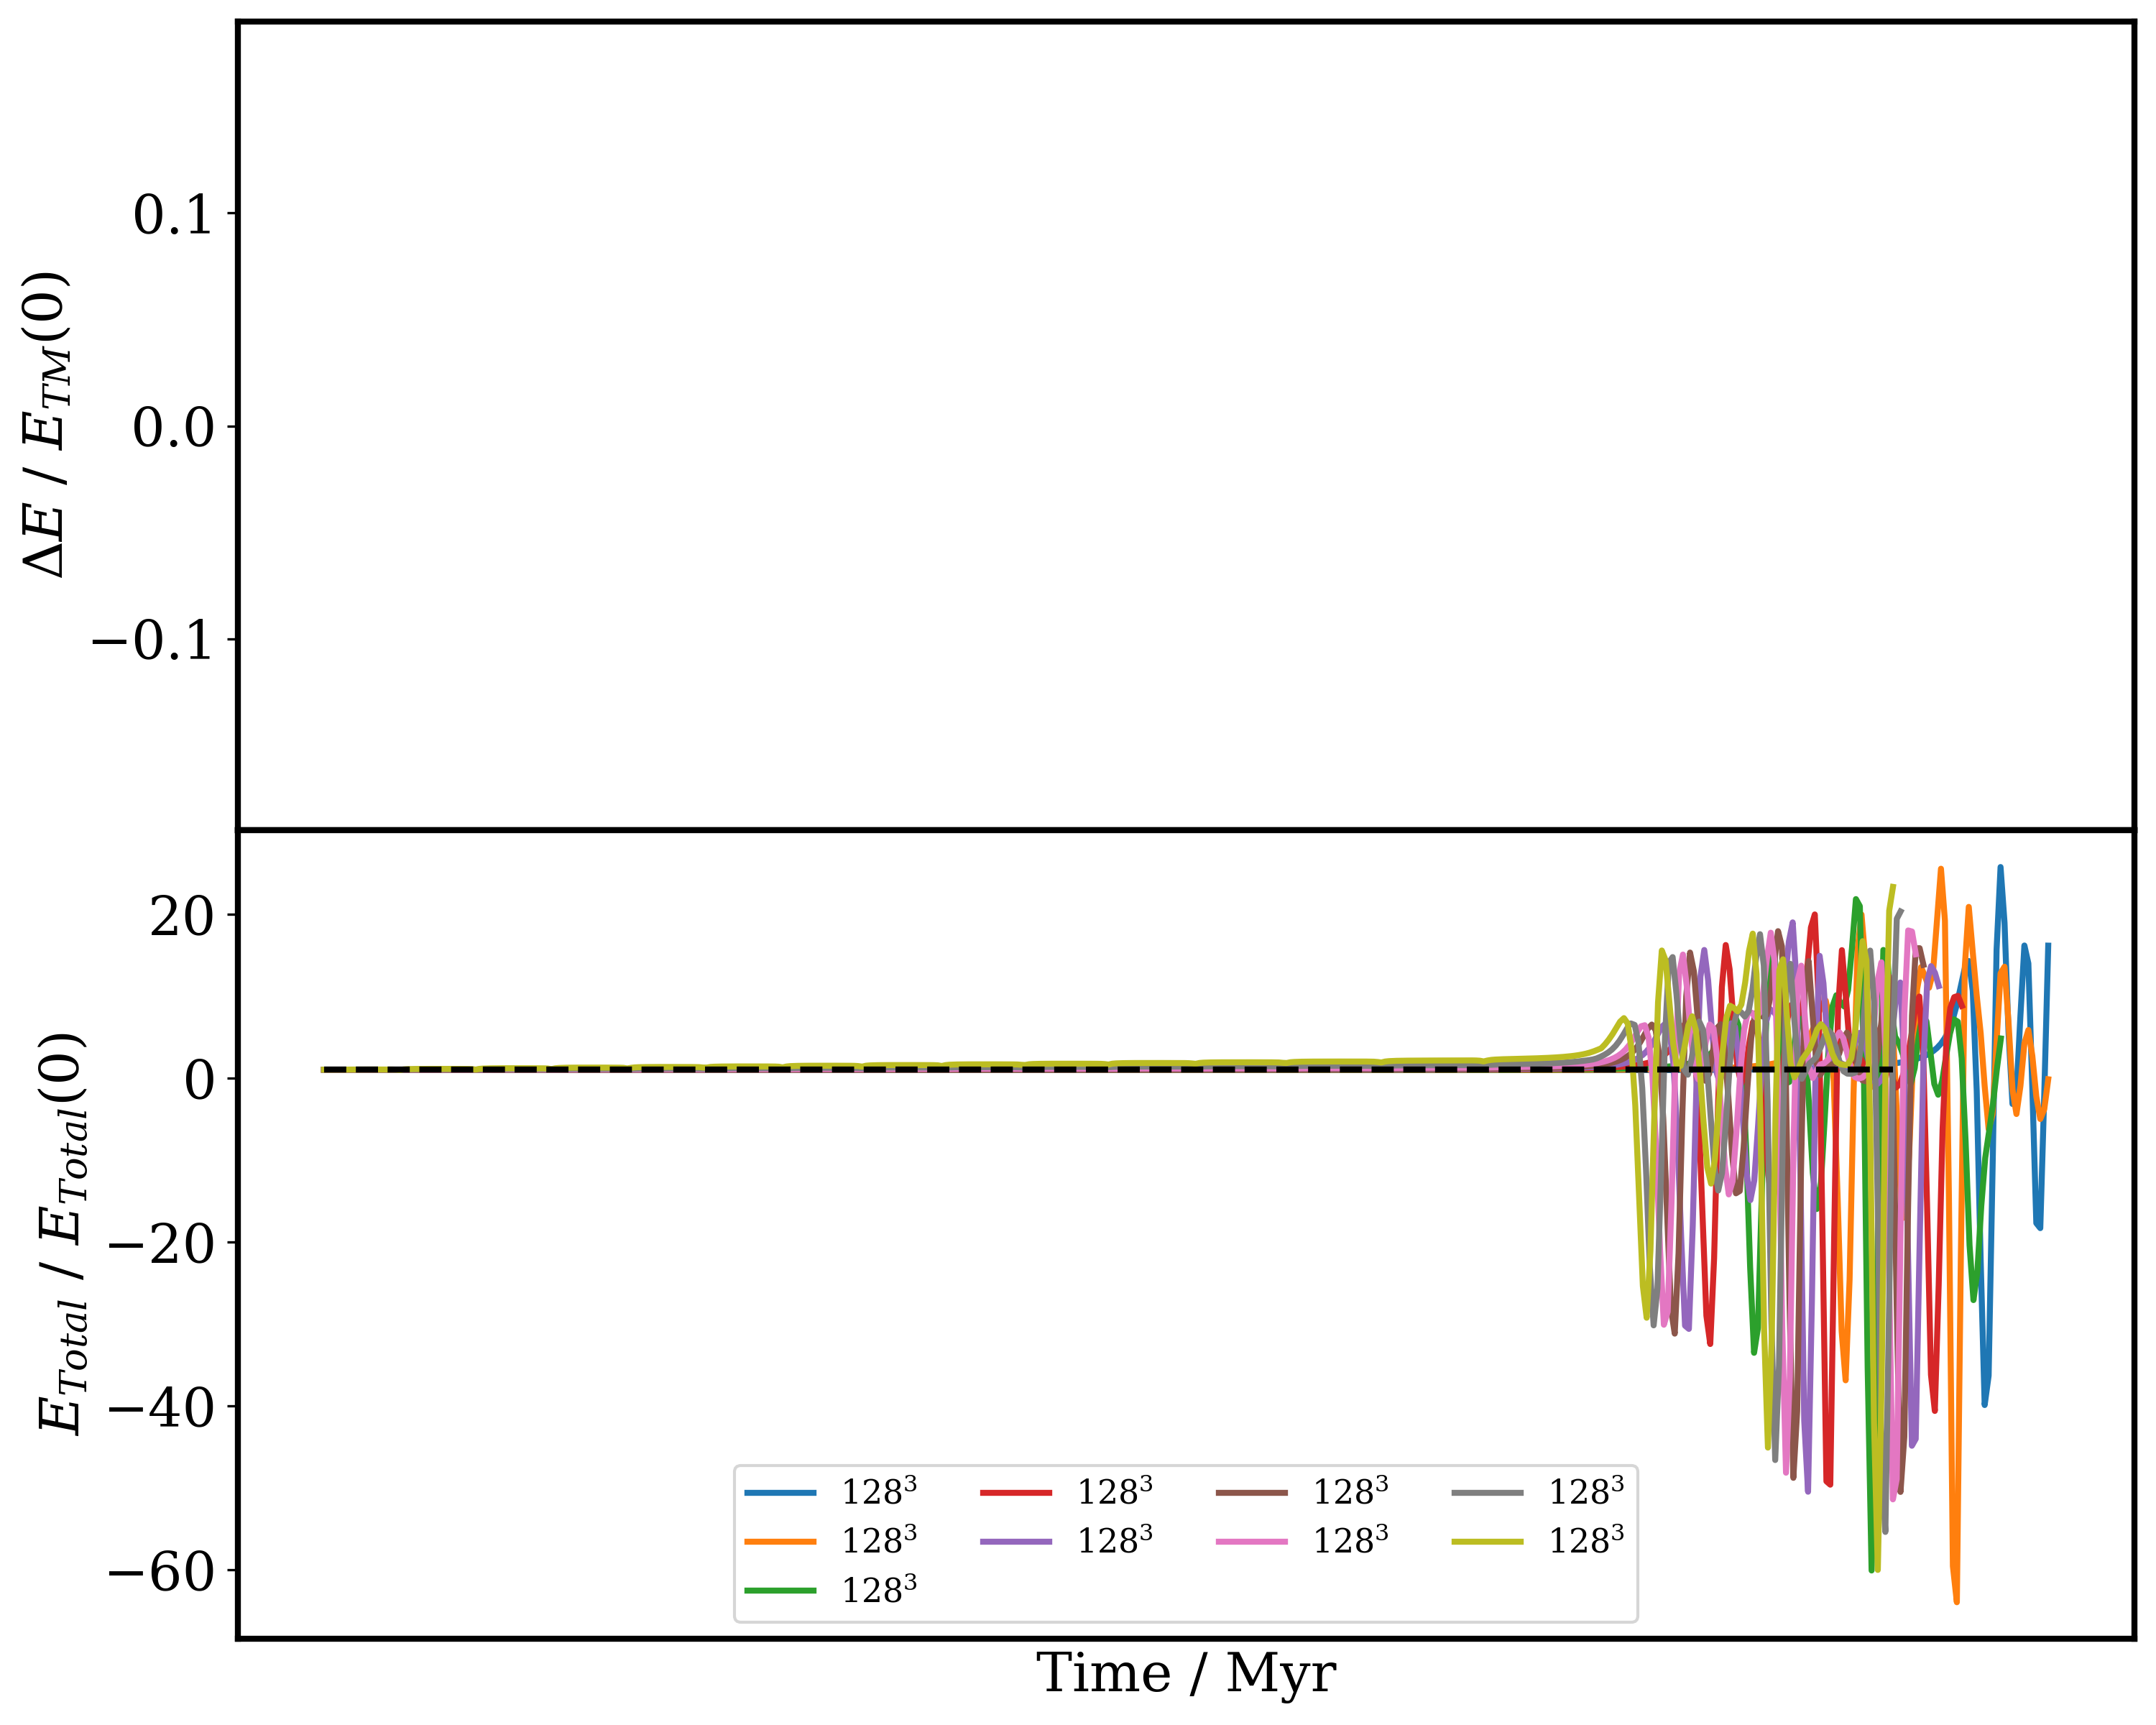

In [40]:
BaseGrid = plt.GridSpec(2, 1, hspace=0)
fig = plt.figure(figsize = (10,8), dpi = 300)

axF = fig.add_subplot(BaseGrid[0,0],xticks = [])
ax = fig.add_subplot(BaseGrid[1,0],sharex = axF)

plt.subplots_adjust(wspace=0, hspace=0)

j = -1
for i in zip(TLog,RLog,EDLog,EULog,KLog,aLog,LLog):
    j += 1
    #plt.plot(i[0],i[3],label = f'{i[1]}')
    #plt.plot(i[0],i[4],label = f'{i[1]}')
    ax.plot(i[0],i[2],label = f'{i[1]}$^3$')

ax.plot(Tp,Tp*0+1,'k--')

axF.set_ylim(-0.19,0.19)

#ax.set_yticks([-0.01,0.,0.01])
#ax.set_yticklabels(['$-$1‱','0‱','1‱'])

ax.set_xlabel('Time / Myr')
ax.set_ylabel('$E_{Total}$ / $ E_{Total}(0)$')

#axF.plot(Tp,TotalED/KS[0],ETStyle,color = ETColor, label = '$\Delta E_{Total}$')
#axF.plot(Tp,egylistD/KS[0],ETStyle,color = EUColor, label = '$\Delta E_{ULDM}$')
#axF.plot(Tp,(KSD+PSD)/KS[0],ETStyle,color = ENColor, label = '$\Delta E_{TM}$')
#axF.legend(loc = 'upper left',frameon = True, fontsize = 12)

#axF.set_xlabel('Time / Myr')
axF.set_ylabel('$\Delta E$ / $E_{TM}(0)$')

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

#plt.ylim([0.999998,1.000002])


ax.legend(ncol = 4,loc = 8, fontsize = 11)

plt.show()

In [64]:
len(RLog)

18

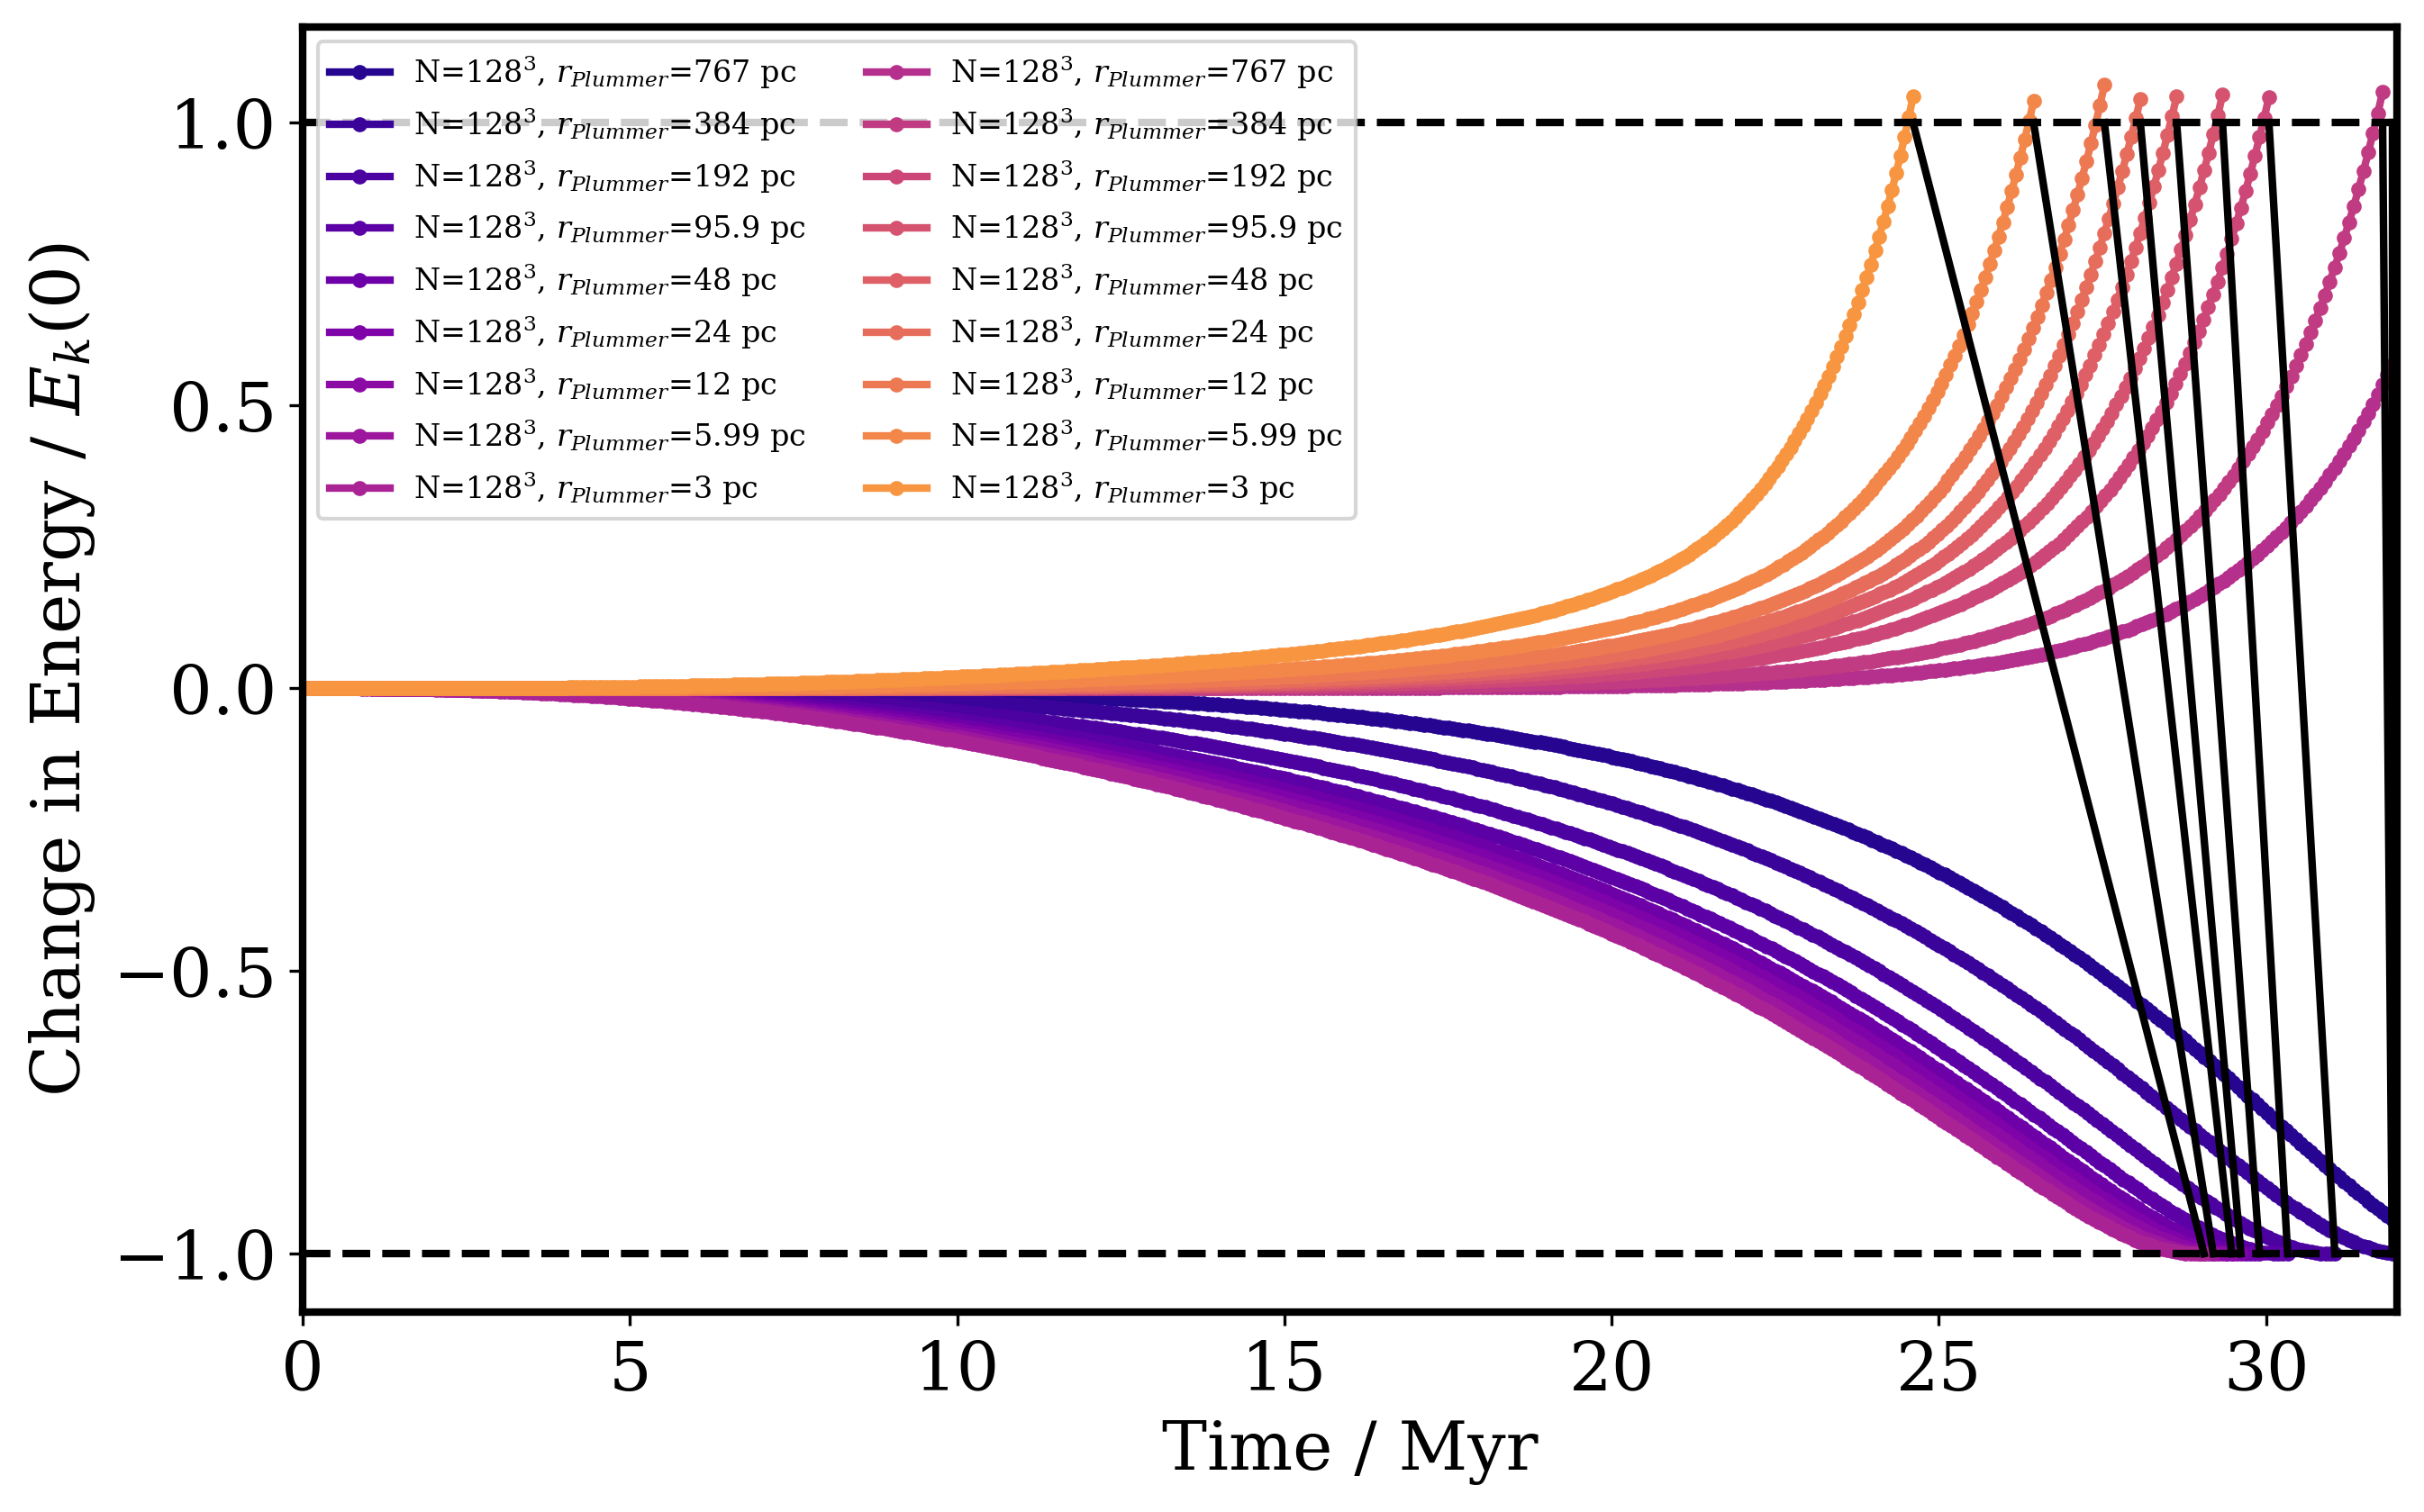

In [70]:
fig = plt.figure(figsize = (10,6.18), dpi = 300)
ax = fig.add_subplot(111)

EColors = plt.cm.plasma(np.linspace(0,1,25))
j = 0
for i in zip(TLog,RLog,EDLog,EULog,KLog,aLog,SFLog,LLog):

    if i[6] == 0.2 and i[1] > 100:# and i[5] > 200 and i[7] < 30 and i[5]==3200:
        
        a = i[5]
        
        PR = 1/PyUL.convert(a,'pc','l')
        
        j += 1
    #plt.plot(i[0],i[3],label = f'{i[1]}')
    #plt.plot(i[0],i[4],label = f'{i[1]}')
        ax.plot(i[0],i[4],'.-',label = f'N={i[1]}$^3$, $r_{{Plummer}}$={PR:.3g} pc', color = EColors[j])

for i in range(9):
    plt.plot([TLog[i][-1],TLog[i+9][-1]],[-1,1],'k-')
        
ax.plot([0,32],[-1,-1], 'k--')    
ax.plot([0,32],[1,1], 'k--') 

ax.set_ylabel(f'Change in Energy / {EUnit}')
plt.xlabel('Time / Myr')
plt.xlim(0,32)
plt.legend(fontsize = 8, ncol = 2)

## Evolving Density in Time

In [ ]:
SnapList = []
PsiRList = []
TMList = []

In [ ]:
print(EndNum)

NSlices = 6

for i in range(NSlices):

    I = i*(EndNum//NSlices)

    PsiR = (data[I]/Density)-1

    TMList.append(TMDataS[I,1])
    SnapList.append(Tp[I])
    PsiRList.append(PsiR[resol//2,:])

In [ ]:
colors = plt.cm.RdPu_r(np.linspace(0,0.7,NSlices))

In [ ]:

Offset = 0

OffsetH = 0

fig, ax = plt.subplots(figsize = (16,8))

fig.patch.set_facecolor('white')
fig.patch.set_alpha(1)

ax.set_ylabel('Overdensity')
ax.set_xlabel('x / kpc')

for i in range(len(SnapList)):
    
    Data = PsiRList[i]
    SnapNbr = SnapList[i]
    
    color = colors[i]
    
    ax.plot(GridVecR-TMList[i],Data,'-',
            label = f'$t = {SnapNbr:.1f}${duration_units}',
           color = color, alpha = 0.6, lw = 4)
    ax.fill_between(GridVecR-TMList[i],Data,0, alpha = 0.2, color = color)
#ax.plot(GridVecR-TML,Coolline,'x',label = f'Simulated Line')



ax.plot(GridVecR-NSGTML,NSGData,'-',
        label = f'$t = {SnapNbr:.1f}${duration_units} (No Self Gravity)',
        color = 'blue',
       lw = 4)
ax.fill_between(GridVecR-NSGTML,NSGData,0, alpha = 0.1, color ='blue')

ax.plot(GridVecL/2/np.pi,Hypr[resolA//2+OffsetH,:],'k--', 
        label = 'Analytical Solution',
       lw = 4)

ax.scatter([0],[0],marker = '.',color = 'k', s = 200)

plt.xlim(-7.5,3)

plt.ylim(-0.05,0.3)


ax.legend(ncol = 1, fontsize = 15)


## Collapse Stability

In [ ]:
XLog = [] # X
RLog = [] # Resolution
TLog = [] # Tp
DLog = [] # Data
YLog = [] # Density

In [ ]:
batch_path = './Batches/' + PyUL.Runs('./Batches', Automatic = False)

runs = os.listdir(batch_path)
runs.sort()

Run = 0
for run_folder in runs:
    
    if os.path.isdir(f'{batch_path}/{run_folder}'):
        print(run_folder)
        
        TimeStamp = run_folder
        
        loc = './' + batch_path + '/' + TimeStamp
        # Reload Config.. Why don't I use a class?
        NS, central_mass, length, length_units, resol, duration, duration_units, step_factor, save_number, save_options, save_format, s_mass_unit, s_position_unit, s_velocity_unit, solitons,start_time, m_mass_unit, m_position_unit, m_velocity_unit, particles, embeds, Uniform,Density, density_unit ,a, B, UVel = PyUL.LoadConfig(loc)

        if save_number == -1:
            sim_number = PyUL.ULDStepEst(duration,duration_units,
                                                  length,length_units,
                                                  resol,step_factor, 
                                                  save_number = -1)
        else:
            sim_number = save_number

        # Dict of Run Data
        EndNum, Loaded = PyUL.Load_npys(loc,save_options)
        

        phi1D  = Loaded['1Grav']
        phiF1D = Loaded['1GravF']

        linedata = Loaded['1Density']

        # Time
        durationMyr = CB(duration,duration_units,'Myr','t') * (EndNum-1) / sim_number

        # Space
        lengthKpc = CB(length,length_units,'kpc','l')
        lengthC = ToCode(length,length_units,'l')

        # Mass

        MassList_MSol = []
        MassListSI = []
        for TM in particles:
            MassList_MSol.append(CB(TM[0],m_mass_unit,'M_solar_masses','m'))
            MassListSI.append(CB(TM[0],m_mass_unit,'kg','m'))

        # Density
        densitySI = ToPhys(ToCode(Density,density_unit,'d'),'kg/m3','d')

        ## Misc. Pre-Multipliers

        Tp = np.linspace(0,EndNum-1,EndNum)
        Tp = Tp * durationMyr / (sim_number+1)

        # NBody_State Vector

        XPre = ToPhys(1,'kpc','l')
        VPre = ToPhys(1,'km/s','v')

        XPreSI = ToPhys(1,'m','l')
        VPreSI = ToPhys(1,'m/s','v')


        # Rho data

        DPre = ToPhys(1,'kg/m3','d')

        # Energy
        EPre = PyUL.energy_unit

        # Field Strength
        PPre = PyUL.mass_unit / PyUL.length_unit
        YLog.append(Density)
        XLog.append(np.linspace(-lengthKpc/2, lengthKpc/2,resol,endpoint = False)) # X
        RLog.append(resol) # Resolution
        TLog.append(Tp) # Tp
        DLog.append(linedata)

In [ ]:
plt.figure(figsize = (10,5))


plt.plot(XLog[0],DLog[0][0],'--',lw = 5, alpha = 0.5)

for i in range(44):
    #plt.plot(XLog[i],DLog[i][0],'--',lw = 3, alpha = 0.5)
    plt.plot(XLog[i],DLog[i][-1],'-',lw = 5, alpha = 0.1)
    
plt.xlabel('x / kpc')
plt.ylabel('Overdensity')

In [ ]:
plt.figure(figsize = (10,5))


for j in range(200):
    for i in range(3):
        plt.scatter(RLog[i],np.max(DLog[i][j]),color = 'w', alpha = j/600)
       
plt.xticks([128,192,256])
plt.xlabel('Resolution (~Box Size)')
plt.ylabel('Overdensity')

## Dual Time Series Compare

This section is for Use with ** Dynamical Friction ** presets only.

In [ ]:
DLog = []
TLog = []
CLog = []
MLog = []
YLog = []
ELog = []
XLog = []

In [ ]:
# save_path = batch_path
TimeStamp = PyUL.Runs(save_path)
clear_output()
loc = './' + save_path + '/' + TimeStamp
# Reload Config.. Why don't I use a class?
NS, central_mass, length, length_units, resol, duration, duration_units, step_factor, save_number, save_options, save_format, s_mass_unit, s_position_unit, s_velocity_unit, solitons,start_time, m_mass_unit, m_position_unit, m_velocity_unit, particles, embeds, Uniform,Density, density_unit ,a, B, UVel = PyUL.LoadConfig(loc)

if save_number == -1:
    sim_number = PyUL.ULDStepEst(duration,duration_units,
                                          length,length_units,
                                          resol,step_factor, 
                                          save_number = -1)
else:
    sim_number = save_number
    
# Dict of Run Data
EndNum, Loaded = PyUL.Load_npys(loc,save_options)
TMdata = Loaded['NBody']
linedata = Loaded['1Density']
graddata = Loaded['DF']

print(Loaded['Directory'])
Loaded = {}

NBo = len(particles)

# Time
durationMyr = CB(duration,duration_units,'Myr','t') * (EndNum-1) / sim_number

# Space
lengthKpc = CB(length,length_units,'kpc','l')
lengthC = ToCode(length,length_units,'l')

# Mass

MassList_MSol = []
MassListSI = []
for TM in particles:
    MassList_MSol.append(CB(TM[0],m_mass_unit,'M_solar_masses','m'))
    MassListSI.append(CB(TM[0],m_mass_unit,'kg','m'))
    
# Density
DensitySI = CB(Density,density_unit,'kg/m3','d')
DensityC = ToCode(Density,density_unit,'d')

YLog.append(DensityC)

## Misc. Pre-Multipliers

Tp = np.linspace(0,EndNum-1,EndNum)
Tp = Tp * durationMyr / (sim_number+1)

# NBody_State Vector

XPre = ToPhys(1,'kpc','l')
VPre = ToPhys(1,'km/s','v')

XPreSI = ToPhys(1,'m','l')
VPreSI = ToPhys(1,'m/s','v')

IArray = np.arange(len(TMdata[0]))

# Dimensionful NBody State

TMDataS = np.array(TMdata)
TMDataSI = np.array(TMdata)

TMDataS[:,IArray % 6 <= 2] *= XPre
TMDataS[:,IArray % 6 >= 3] *= VPre


TMDataSI[:,IArray % 6 <= 2] *= XPreSI
TMDataSI[:,IArray % 6 >= 3] *= VPreSI


DLog.append(linedata)
MLog.append(TMDataS)

DPre = CB(1,density_unit,'kg/m3','d')
# DYNFRIC

vRel0 = -CB(UVel[1],s_velocity_unit,'m/s','v') + TMDataSI[:,4]

mBH = MassList_MSol[0] # Million MSols
mBH_kg = CB(mBH,'M_solar_masses','kg','m')

lR = PyUL.hbar/(PyUL.axion_mass*vRel0) # Has a factor of 2pi removed.

lRP = PyUL.convert_between(lR,'m','pc','l')

# Quantum Mach Number

MQ = 44.56*vRel0/1000*(((1e-22*PyUL.eV))/PyUL.axion_mass)/mBH/10

beta = 2*np.pi*PyUL.G*mBH_kg/(vRel0[0])**2/(lR[0])

# Reference Force Value

FRel = 4*np.pi*Density*DPre*(PyUL.G*mBH*1e6*PyUL.solar_mass/(vRel0))**2

# Time in seconds
TpSec = CB(Tp,'Myr','s','t')

# Motion due to Particle Movement
dSim = TMDataSI[:,1] - TMDataSI[0,1]

vQW = -1*CB(UVel[1],s_velocity_unit,'m/s','v')

dQW = vQW*TpSec

bSI = dQW + dSim

bV = CB(bSI,'m','pc','l')

BVTilde = bV/lRP

Lambda = BVTilde/beta

# Expected DynDrag

CLambda = np.log(2*Lambda) + 1/Lambda*np.log(2*Lambda) - 1


# Gravitational Attraction of DM Wake
CLogDF2 = -1*np.array(graddata)[:,1] * PyUL.length_unit/PyUL.time_unit**2 # 1 Code Acceleration Unit

# Phi is already in m/s^2 

Crel = CLogDF2*vRel0**2/(4*np.pi*CB(Density,density_unit,'kg/m3','d')*PyUL.G**2*mBH_kg)

PlotRange = np.linspace(-lengthKpc/2, lengthKpc/2,resol,endpoint = False)
# Exact Evaluation

from scipy.special import sici as SiCin

SbV,CbV = SiCin(2*BVTilde)

RealCbV = np.euler_gamma + np.log(2*BVTilde) - CbV

CrelV = RealCbV+np.sin(2*BVTilde)/(2*BVTilde)-1

CrelMax = np.max(Crel)

TLog.append(BVTilde)
CLog.append(Crel)

ELog.append(EndNum)

XLog.append(PlotRange)

Loaded = {}

### The 1-Dimensional Slice

In [ ]:
YLog

In [ ]:
Step = 34
VOffset = 0.003
Sotal = EndNum // Step
Cutoff = 167


NSamples = len(DLog)

C1 = 'goldenrod'
C2 = 'darkolivegreen'
C3 = 'plum'
C4 = 'cadetblue'


Cs = [C1,C2,C3,C4]


fig = plt.figure(figsize = (16,9))

ax = fig.add_subplot(111)

plt.setp(ax.spines.values(), linewidth=1)

for i in range(Cutoff):
    if i%Step == 0:
        Alpha = 0.5
        LW = 2
        
        #plt.plot(PlotRange,0*PlotRange+1+VOffset*i,'--',alpha = 1, color = 'k', lw = 1)
        
        #plt.plot(PlotRange,DLog[0][i]/DensityC+VOffset*i,'-',alpha = Alpha, color = C1, lw = 3)
        #plt.plot(PlotRange,DLog[1][i]/DensityC+VOffset*i,'-',alpha = Alpha, color = C2, lw = 3)

            
        for J in range(NSamples):
            
            j = -J
            
            print(len(XLog[j]),len(DLog[j][i]))
            
            try:
                plt.fill_between(XLog[j],DLog[j][i]/YLog[j]+VOffset*i,1+VOffset*i,alpha = Alpha, color = Cs[J], 
                                 lw = LW, zorder = 100+j*10)
                
                plt.scatter([MLog[j][i,1]],[1+VOffset*i],c = Cs[J], alpha = 1, zorder = 300 + 20*J)

            except IndexError:
                print(f'Branch #{j} ran out of data points ({ENum[j]} vs. {i}).')
                continue

for j in range(NSamples):
    
    Cutoff = np.min([Cutoff,ELog[j]])
    
    #plt.plot(MLog[j][:Cutoff,1],np.arange(Cutoff)*VOffset+1,'-.', color = Cs[j], lw = 2, alpha = 0.5)
            
plt.ylabel(r'Time $\longrightarrow$')
plt.xlabel(r'x / kpc')
plt.yticks([])
plt.xlim(0.,7.5)

### Main Framework

In [ ]:
plt.figure(figsize = (10,8))

BLine = np.linspace(-2,3,300)

BLineX = 10**BLine

rSys = PyUL.convert_between(length*BLineX,length_units,'m','l')

Lambda = vRel0[0]**2*rSys/(PyUL.G*mBH_kg)

# Classical B

C_Cl = np.log(2*Lambda) - 1 + 1/Lambda*np.log(2*Lambda)

F_Cl = 4*np.pi*PyUL.G**2*mBH_kg**2*DensityC*PyUL.convert_back(1,'kg/m3','d')/(vRel0[0]**2)*C_Cl / FRel[0]

# Classical A

C_A = (1+Lambda)/(Lambda)*np.arctanh(np.sqrt(Lambda**2+2*Lambda)/(1+Lambda)) - np.sqrt(1+2/Lambda)


plt.loglog(BLineX,C_A,'--',
           color = EmphColor, label = 'Classical Dynamical Friction Limit')

#plt.loglog(BLineX,C_Cl,'--',label = 'Classical Dynamical Friction Limit B')

from scipy.special import sici as SiCin

Sb,Cb = SiCin(2*BLineX)

RealCb = np.euler_gamma + np.log(2*BLineX) - Cb

plt.loglog(BLineX,RealCb+np.sin(2*BLineX)/(2*BLineX)-1,
           color = EmphColor, label = 'Coulomb Scattering Result')

#plt.loglog(BLineX,1/3*BLineX**2,color = 'green',label = 'Lancaster Low b Asymptote')

from scipy.special import digamma as Dig

beta = PyUL.G*mBH_kg/(vRel0[0]**2*lR[0])


plt.scatter(TLog[0],CLog[0],label = 'Coulomb Simulation' ,  color = C1, s = 35, marker = 'x')
plt.scatter(TLog[1],CLog[1],label = 'Full Simulation' ,  color = C2, s = 35, marker = '1')
#plt.fill_betweenx(Crel,BCutTildeMin, BCutTildeMax,  color = 'r', alpha = 0.2)


plt.xticks([0.1,1,10,100,1000])
plt.yticks([0.1,1,10])

plt.xlabel('$\~{b} $')
plt.ylabel('$C$ ')

plt.ylim(0.005,300)

#plt.xlim(0.05,200)

plt.legend(ncol = 2, fontsize = 12)

## Potential Well Depth and Energy Smoothness

In [ ]:
aLog = []
RLog = []
TLog = []
LLog = []
FLog = []
xLog = []

ETLog = []
ERLog = []
GFLog = []
GULog = []
EKLog = []

BVLog = []
CRLog = []

In [ ]:
runs = os.listdir(batch_path)
runs.sort()

for TimeStamp in runs:
    
    if os.path.isdir(f'{batch_path}/{TimeStamp}'):
        
        clear_output()
        loc = './' + batch_path + '/' + TimeStamp
        # Reload Config.. Why don't I use a class?
        NS, central_mass, length, length_units, resol, duration, duration_units, step_factor, save_number, save_options, save_format, s_mass_unit, s_position_unit, s_velocity_unit, solitons,start_time, m_mass_unit, m_position_unit, m_velocity_unit, particles, embeds, Uniform,Density, density_unit ,a, B, UVel = PyUL.LoadConfig(loc)

        if save_number == -1:
            sim_number = PyUL.ULDStepEst(duration,duration_units,
                                                  length,length_units,
                                                  resol,step_factor, 
                                                  save_number = -1)
        else:
            sim_number = save_number

        # Dict of Run Data
        EndNum, Loaded = PyUL.Load_npys(loc,save_options)

        TMdata = Loaded['NBody']
        linedata = Loaded['1Density']
        graddata = Loaded['DF']
        phiF1D = Loaded['1GravF']
        phi1D = Loaded['1Grav']

        print(Loaded['Directory'])
        Loaded = {}

        NBo = len(particles)

        PlotRange = np.linspace(-lengthKpc/2, lengthKpc/2,resol,endpoint = False)
        print(f'SIM NUMBER IS {sim_number}')
        # Time
        durationMyr = CB(duration,duration_units,'Myr','t') * (EndNum-1) / sim_number

        # Space
        lengthKpc = CB(length,length_units,'kpc','l')
        lengthC = ToCode(length,length_units,'l')

        # Mass

        MassList_MSol = []
        MassListSI = []
        for TM in particles:
            MassList_MSol.append(CB(TM[0],m_mass_unit,'M_solar_masses','m'))
            MassListSI.append(CB(TM[0],m_mass_unit,'kg','m'))

        # Density
        DensitySI = CB(Density,density_unit,'kg/m3','d')
        DensityC = ToCode(Density,density_unit,'d')

        ## Misc. Pre-Multipliers


        # NBody_State Vector

        XPre = ToPhys(1,'kpc','l')
        VPre = ToPhys(1,'km/s','v')

        XPreSI = ToPhys(1,'m','l')
        VPreSI = ToPhys(1,'m/s','v')

        IArray = np.arange(len(TMdata[0]))

        # Dimensionful NBody State

        TMDataS = np.array(TMdata)
        TMDataSI = np.array(TMdata)

        TMDataS[:,IArray % 6 <= 2] *= XPre
        TMDataS[:,IArray % 6 >= 3] *= VPre


        TMDataSI[:,IArray % 6 <= 2] *= XPreSI
        TMDataSI[:,IArray % 6 >= 3] *= VPreSI


        # Rho data
        DPre = CB(1,density_unit,'kg/m3','d')
        # Energy
        EPre = PyUL.energy_unit
        # Field Strength
        PPre = PyUL.mass_unit / PyUL.length_unit

        # Translating Snapshots back to Time
        timerange = np.linspace(0,durationMyr,save_number+1)

        Tp = np.arange(EndNum)

        print(Tp)

        Tp = Tp * durationMyr / (sim_number+1)

        print(Tp)

        egylist = np.load('{}{}'.format(loc, '/Outputs/egylist.npy'),allow_pickle=True) * EPre
        egpcmlist2 = np.load('{}{}'.format(loc, '/Outputs/egpcmlist.npy'),allow_pickle=True) * EPre
        egpcmlist = np.load('{}{}'.format(loc, '/Outputs/egpcmMlist.npy'),allow_pickle=True) * EPre # Using Interpolation
        egpsilist = np.load('{}{}'.format(loc, '/Outputs/egpsilist.npy'),allow_pickle=True) * EPre
        ekandqlist = np.load('{}{}'.format(loc, '/Outputs/ekandqlist.npy'),allow_pickle=True) * EPre
        mtotlist = np.load('{}{}'.format(loc, '/Outputs/masseslist.npy'),allow_pickle=True) * EPre

        # Reconstruct NBody Energy (Real)
        NBo, KS, PS = PyUL.NBodyEnergy(MassListSI,TMDataSI,EndNum, a, length_units)

        KSD = KS - KS[0]
        PSD = PS - PS[0]

        TotalER = (KS + PS + egylist) / (KS[0]+PS[0]+egylist[0])

        egylistD = egylist - egylist[0]
        TotalED = PSD+KSD+egylistD



        Masses = [particle[0] for particle in particles]
        
        mBH = MassList_MSol[0] # Million MSols
        mBH_kg = CB(mBH,'M_solar_masses','kg','m')

        
        
                
        ##### DYNAMICAL FRICTION FRAMEWORK
        
        # Density
        densitySI = CB(Density,density_unit,'kg/m3','d')


        ## Misc. Pre-Multipliers
        
        XPre = ToPhys(1,'kpc','l')
        VPre = ToPhys(1,'km/s','v')

        XPreSI = ToPhys(1,'m','l')
        VPreSI = ToPhys(1,'m/s','v')

        IArray = np.arange(len(TMdata[0]))

        # Dimensionful NBody State

        TMDataS = np.array(TMdata)
        TMDataSI = np.array(TMdata)

        TMDataS[:,IArray % 6 <= 2] *= XPre
        TMDataS[:,IArray % 6 >= 3] *= VPre

        TMDataSI[:,IArray % 6 <= 2] *= XPreSI
        TMDataSI[:,IArray % 6 >= 3] *= VPreSI

        # Rho data

        DPre = CB(1,density_unit,'kg/m3','d')

        # Energy
        EPre = PyUL.energy_unit

        # Field Strength
        PPre = PyUL.mass_unit / PyUL.length_unit

        ######### DYNFNB 2021-04-07
        vRel0 = -CB(UVel[1],s_velocity_unit,'m/s','v') + TMDataSI[:,4]

        lR = PyUL.hbar/(PyUL.axion_mass*vRel0) # Has a factor of 2pi removed.

        lRP = PyUL.convert_between(lR,'m','pc','l')

        # Quantum Mach Number

        MQ = 44.56*vRel0/1000*(((1e-22*PyUL.eV))/PyUL.axion_mass)/mBH/10

        beta = 2*np.pi*PyUL.G*mBH_kg/(vRel0[0])**2/(lR[0])

        # Reference Force Value

        FRel = 4*np.pi*Density*DPre*(PyUL.G*mBH*1e6*PyUL.solar_mass/(vRel0))**2

      
        # Time in seconds
        TpSec = CB(Tp,'Myr','s','t')

        # Motion due to Particle Movement
        dSim = TMDataSI[:,1] - TMDataSI[0,1]

        vQW = -1*CB(UVel[1],s_velocity_unit,'m/s','v')

        dQW = vQW*TpSec

        bSI = dQW + dSim

        bV = CB(bSI,'m','pc','l') 

        BVTilde = bV/lRP

        Lambda = BVTilde/beta

        # Expected DynDrag

        CLambda = np.log(2*Lambda) + 1/Lambda*np.log(2*Lambda) - 1

        TpSec = CB(Tp,'Myr','s','t')


        # Gravitational Attraction of DM Wake
        CLogDF2 = -1*np.array(graddata)[:,1] * PyUL.length_unit/PyUL.time_unit**2 # 1 Code Acceleration Unit
        Crel = CLogDF2*vRel0**2/(4*np.pi*PyUL.convert_back(Density,'kg/m3','d')*PyUL.G**2*mBH_kg)

        BVLog.append(BVTilde)
        CRLog.append(Crel)

        

        MDi = [np.min(phiF1D[i]) for i in range(EndNum)]
        UDi = [np.min(phi1D[i]) for i in range(EndNum)]

        aLog.append(a)
        RLog.append(resol)
        TLog.append(Tp)
        ETLog.append(TotalED)
        ERLog.append(TotalER)
        GULog.append(UDi)
        GFLog.append(MDi)
        
        
        LLog.append(linedata)
        EKLog.append(KS)
        FLog.append(phiF1D)
        xLog.append(PlotRange)
        print(a)
        
colors = plt.cm.gist_rainbow(np.linspace(0,1,len(RLog)))

clear_output()

In [ ]:
I = 0
plt.figure(figsize = EFigSize)

for it in zip(TLog,GULog,aLog,GFLog):
    
    xT, yG,a, yF = it[0], it[1], it[2],it[3]
    
    plt.plot(xT,yG,label = f'{a}',color = colors[I])
    plt.plot(xT,yF,color = colors[I], alpha = 0.4)
    
    I += 1

    
# plt.plot([0,durationMyr],[1,1],'--', color = EmphColor)
plt.ylabel('$Φ_{Max\ Sim} (Deepest ULDM Potential Point)')
plt.xlabel('Time / Myr')

# plt.ylim(0.1,10)

plt.legend(title = '$a$',fontsize = 12)

In [ ]:
I = 0

plt.figure(figsize = EFigSize)

for it in zip(TLog,ERLog,aLog):
    
    xT, yE,a = it[0], it[1], it[2]
    
    plt.plot(xT,yE,label = f'{a}', color = colors[I])
    I += 1

#plt.plot([0,50],[1,1],'--', color = EmphColor)
    
plt.ylabel('$E/E_0$')
plt.xlabel('Time / Myr')



plt.annotate('Too Smooth', xy=(0.3, 0.27),  xycoords='axes fraction',
            xytext=(0.1, 0.27), textcoords='axes fraction',)

plt.annotate('Too Sharp', xy=(0.3, 0.67),  xycoords='axes fraction',
            xytext=(0.1, 0.67), textcoords='axes fraction',)

plt.legend(title = '$a$')

In [ ]:
I = 0


plt.figure(figsize = EFigSize)

for it in zip(TLog,EKLog,aLog):
    
    xT, yE, a = it[0], it[1], it[2]
    
    plt.plot(xT,yE,label = f'{a}', color = colors[I])
    
    I += 1


    
plt.ylabel('$E_k$')
plt.xlabel('Time / Myr')

plt.legend(title = '$a$')

In [ ]:
Slice = -1

plt.figure(figsize = EFigSize)
I = 0

for i in zip(aLog,xLog,FLog):
    
    try:
        plt.plot(i[1],i[2][Slice], label =f'{i[0]}',color = colors[I])
        I+=1
    except:
        I+=1
    
plt.legend()


In [ ]:
len(TLog[-1])

In [ ]:
EKLog

In [ ]:
Slice = -1

plt.figure(figsize = EFigSize)
I = 0


print(aLog)

for i in zip(aLog,xLog,LLog,RLog):
    
    if i[0] != 400 and i[0] != 3200 and i[0] != 25600:
        continue
    try:

        
        if i[3] == 128:
            style = '--'
            
        elif i[3] == 192:
            style = '.-.'
            
        elif i[3] == 256:
            style = '-'
        
        plt.plot(i[1],i[2][Slice], style, label =f'a = {i[0]}, N = {i[3]}')
        I+=1
    except:
        I+=1
    
plt.legend()

plt.xlabel('x / kpc')
plt.ylabel('Code Density')

In [ ]:



Slice = 100

plt.figure(figsize = EFigSize)


BLine = np.linspace(-2,3,300)

BLineX = 10**BLine

rSys = PyUL.convert_between(length*BLineX,length_units,'m','l')

Lambda = vRel0[0]**2*rSys/(PyUL.G*mBH_kg)

# Classical A

C_A = (1+Lambda)/(Lambda)*np.arctanh(np.sqrt(Lambda**2+2*Lambda)/(1+Lambda)) - np.sqrt(1+2/Lambda)


#plt.loglog(BLineX,C_A,'--',
#          color = EmphColor, label = 'Classical Limit')

#plt.loglog(BLineX,C_Cl,'--',label = 'Classical Dynamical Friction Limit B')

from scipy.special import sici as SiCin

Sb,Cb = SiCin(2*BLineX)

RealCb = np.euler_gamma + np.log(2*BLineX) - Cb

plt.loglog(BLineX,RealCb+np.sin(2*BLineX)/(2*BLineX)-1, '--',
           color = EmphColor, label = 'Coulomb Scattering Result')

#plt.loglog(BLineX,1/3*BLineX**2,color = 'green',label = 'Lancaster Low b Asymptote')

from scipy.special import digamma as Dig

beta = PyUL.G*mBH_kg/(vRel0[0]**2*lR[0])

#plt.loglog(BLineX,np.log(2*BLineX)-1-np.real(Dig(1+1j*beta)),color = 'orange',label = 'Lancaster High b Asymptote')

# Final A is already in m/s^2 
FinalA = CLogDF2

Crel = FinalA*vRel0**2/(4*np.pi*CB(Density,density_unit,'kg/m3','d')*PyUL.G**2*mBH_kg)

#plt.fill_betweenx(Crel,BCutTildeMin, BCutTildeMax,  color = 'r', alpha = 0.2)


plt.xticks([0.1,1,10,100,1000])
plt.yticks([0.1,1,10])

plt.xlabel('$\~{b} $')
plt.ylabel('$C$ ')

plt.ylim(0.005,300)

#plt.xlim(0.05,200)

plt.legend()
I = 0

for i in zip(aLog,BVLog,CRLog):
    
    try:
        plt.loglog(i[1], i[2], label =f'{i[0]}',color = colors[I])
        I+=1
    except:
        I+=1
        
plt.ylim(0.0005,100)
plt.xlim(0.05,120)  
plt.legend()


In [ ]:
a = 102400

# a = 400

print(f"\nSmoothing factor is {a:.3f}, \nThe particle's Plummer radius is {1/ToCode(a,'pc','l'):.4g} pc")